# Pitch Location Regression
The purpose of this notebook is to begin working on regression to predict the pitch location, via its x and z coordinates (px, pz).  In the final product, this will come after classification of the pitch type.  Here, I'll first predict px, then pz, as the horizontal location of the pitch is greatly influenced by the pitch type and its motion.

Importing packages:

In [1]:
import pickle
from sqlalchemy import create_engine
import pandas as pd
from importlib import reload
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

Pickling in initial data to work with:

In [3]:
pwd

'/Users/patrickbovard/Documents/GitHub/metis_final_project/Pitch_Classification'

In [4]:
with open('../Data/cleaned_pitch_df.pickle','rb') as read_file:
    pitch_df = pickle.load(read_file)

In [5]:
pitch_df.drop(columns=['Pitch_Family'], inplace=True)

In [6]:
pitch_df.head()

inning  batter_id  pitcher_id  top         ab_id  p_score stand p_throws  \
0     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
1     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
2     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
3     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
4     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   

       event home_team  ... pitch_num  last_pitch_type  last_pitch_px  \
0  Groundout       chn  ...       1.0             None            NaN   
1  Groundout       chn  ...       2.0               FF          0.416   
2  Groundout       chn  ...       3.0               FF         -0.191   
3  Groundout       chn  ...       4.0               FF         -0.518   
4  Groundout       chn  ...       5.0               FF         -0.641   

   last_pitch_pz  last_pitch_speed  pitcher_full_name  pitcher_run_diff  \
0            NaN               NaN         Jon Lester               0.0   
1          2.963              92.9         Jon Lester               0.0   
2          2.347              92.8         Jon Lester               0.0   
3          3.284              94.1         Jon Lester               0.0   
4          1.221              91.0         Jon Lester               0.0   

  hitter_full_name Date_Time_Date  Season  
0   Matt Carpenter     2015-04-05    2015  
1   Matt Carpenter     2015-04-05    2015  
2   Matt Carpenter     2015-04-05    2015  
3   Matt Carpenter     2015-04-05    2015  
4   Matt Carpenter     2015-04-05    2015  

[5 rows x 34 columns]

For regression, the following columsn will be used as features:
- 'inning', 'top', 'stand', 'p_throws', 'on_1b', 'on_2b', 'on_3b', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed', 'pitcher_run_diff'
- pitch_type will also be used - in my final model, this will be the predicted pitch_types, but for now as a proof of concept I'll be utilizing the actual rows.

# Dataframe Prep

## Split: Train/Val and Test:

For puposes of training/validating and testing my model(s), I'll be splitting as follows: 
- Train/Val: 2015-2018 seasons
- Test: 2019 season  

This is the same as I did for the pitch type classifier in Pitch_Classification_Intro.ipynb.

In [7]:
pitch_df[pitch_df.Season == 2019].shape

(707463, 34)

In [8]:
pitch_df[pitch_df.Season != 2019].shape

(2848371, 34)

## Feature Prep

### One Hot Encoding:

Here, I'll need to one hot encode a few columns - specifically:

- stand (hitter hand), p_throws (pitcher throwing hand), last_pitch_type, pitch_type

In [11]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type', 'pitch_type']

In [12]:
scherzer_df = train_df[train_df.pitcher_full_name == 'Max Scherzer']

In [13]:
from pitch_cat_functions import *

In [14]:
new_df = column_ohe_maker(scherzer_df, ohe_cols)

In [15]:
new_df.head()

inning  batter_id  pitcher_id  top         ab_id  p_score event  \
2396     1.0     434158      453286  1.0  2.015001e+09      0.0  Walk   
2397     1.0     434158      453286  1.0  2.015001e+09      0.0  Walk   
2398     1.0     434158      453286  1.0  2.015001e+09      0.0  Walk   
2399     1.0     434158      453286  1.0  2.015001e+09      0.0  Walk   
2400     1.0     434158      453286  1.0  2.015001e+09      0.0  Walk   

     home_team away_team  b_score  ...  last_pitch_type_FF  \
2396       was       nyn      0.0  ...                 0.0   
2397       was       nyn      0.0  ...                 1.0   
2398       was       nyn      0.0  ...                 1.0   
2399       was       nyn      0.0  ...                 1.0   
2400       was       nyn      0.0  ...                 0.0   

      last_pitch_type_FT  last_pitch_type_SL  last_pitch_type_UN  \
2396                 0.0                 0.0                 0.0   
2397                 0.0                 0.0                 0.0   
2398                 0.0                 0.0                 0.0   
2399                 0.0                 0.0                 0.0   
2400                 0.0                 0.0                 0.0   

      last_pitch_type_None pitch_type_CU  pitch_type_FC pitch_type_FF  \
2396                   1.0           0.0            0.0           1.0   
2397                   0.0           0.0            0.0           1.0   
2398                   0.0           0.0            0.0           1.0   
2399                   0.0           0.0            0.0           0.0   
2400                   0.0           0.0            0.0           1.0   

      pitch_type_FT  pitch_type_SL  
2396            0.0            0.0  
2397            0.0            0.0  
2398            0.0            0.0  
2399            0.0            0.0  
2400            0.0            0.0  

[5 rows x 43 columns]

In [16]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'start_speed', 'type', 'b_count', 's_count', 'outs',
       'pitch_num', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'stand_R', 'last_pitch_type_CU',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'last_pitch_type_None',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT',
       'pitch_type_SL'],
      dtype='object')

### Linear Regression Test:

Here, I'll test out an initial run of my linear regression.

In [17]:
from location_regression_functions import *

In [18]:
columns = ['inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'last_pitch_type_CU',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'last_pitch_type_None',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT',
       'pitch_type_SL']

In [19]:
X = new_df[columns]

In [20]:
y = new_df['px']

In [21]:
split_and_train_val_simple_lr_w_cv(X, y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.1289906699265848, 0.15206934831818453, 0.1822668226018257, 0.1517150641576287, 0.12175620634510198] 

Simple mean cv r^2: 0.147 +- 0.021
MAE Scores: [0.6234395347741104, 0.6377879752975786, 0.6324862514074213, 0.6453973941126377, 0.6507615022407948]
Avg. CV MAE: 0.6379745315665086


Checking on pz, using px as a feature:

In [22]:
cols_pz = ['inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'last_pitch_type_CU',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'last_pitch_type_None',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT',
       'pitch_type_SL', 'px']

In [23]:
X = new_df[cols_pz]

In [24]:
y = new_df['pz']

In [25]:
split_and_train_val_simple_lr_w_cv(X, y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.3258937444050931, 0.3473746158483699, 0.321904875257912, 0.33571035802980265, 0.36807422827988323] 

Simple mean cv r^2: 0.340 +- 0.017
MAE Scores: [0.5590737226418868, 0.5561437669651792, 0.5564611497729697, 0.5649071252121297, 0.5624505363500322]
Avg. CV MAE: 0.5598072601884395


In [26]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.3258937444050931, 0.3473746158483699, 0.321904875257912, 0.33571035802980265, 0.36807422827988323] 

Simple mean cv r^2: 0.340 +- 0.017
MAE Scores: [0.5590737226418868, 0.5561437669651792, 0.5564611497729697, 0.5649071252121297, 0.5624505363500322]
Avg. CV MAE: 0.5598072601884395


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.3424695107123906
Lasso mae: 0.5588967679431889
Lasso Coefficients: [('inning', -0.016094532087446142), ('b_count', 0.026134736340032123), ('s_count', -0.06900330067144024), ('outs', 0.010980627743810464), ('pitcher_run_diff', 0.012555321378606082), ('stand_R', -0.025381930847214643), ('last_pitch_type_CU', -0.028608828839731558), ('last_pitch_type_FC', 0.016615303226127538), ('last_pitch_type_FF', -0.02979824280062424), ('last_pitch_type_FT', 0.0022509001162964158), ('last_pitch_type_SL', -0.039651004280263746), ('last_pitch_type_UN', 0.0015242022962364207), ('last_pitch_type_None',

For this project, I'm not as concerned with R^2, since throwing a pitch to an exact coordinate isn't really a realistic thing to expect to predict.  Pitchers don't have perfect command.  Instead, MAE is my key metric here, since this represents how close my prediction is. 

Right now, the MAE's would translate to being about 7.5" off in the x direction, and about 6.5" off in the z direction.  Ultimately, this does not need to be precisely close, since there is a lot of inherent variance in pitches thrown.  Since even the best pitchers will not be able to throw with pinpoint accuracy, the model mainly needs to capture the "area" the pitch will be in.

# Running on all pitchers:

Since location may be more related to the pitch type than the pitcher, I am going to try running regression on all the pitchers in the train/validation set, to see if that may give the algorithm more data to learn from and improve.

In [27]:
train_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'stand',
       'p_throws', 'event', 'home_team', 'away_team', 'b_score', 'on_1b',
       'on_2b', 'on_3b', 'px', 'pz', 'zone', 'pitch_type', 'start_speed',
       'type', 'b_count', 's_count', 'outs', 'pitch_num', 'last_pitch_type',
       'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season'],
      dtype='object')

In [28]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type', 'pitch_type']

In [29]:
new_df = column_ohe_maker(train_df, ohe_cols)

In [30]:
new_df.head()

inning  batter_id  pitcher_id  top         ab_id  p_score      event  \
0     1.0     572761      452657  1.0  2.015000e+09      0.0  Groundout   
1     1.0     572761      452657  1.0  2.015000e+09      0.0  Groundout   
2     1.0     572761      452657  1.0  2.015000e+09      0.0  Groundout   
3     1.0     572761      452657  1.0  2.015000e+09      0.0  Groundout   
4     1.0     572761      452657  1.0  2.015000e+09      0.0  Groundout   

  home_team away_team  b_score  ...  pitch_type_FC  pitch_type_FF  \
0       chn       sln      0.0  ...            0.0            1.0   
1       chn       sln      0.0  ...            0.0            1.0   
2       chn       sln      0.0  ...            0.0            1.0   
3       chn       sln      0.0  ...            0.0            1.0   
4       chn       sln      0.0  ...            0.0            0.0   

   pitch_type_FO  pitch_type_FS  pitch_type_FT pitch_type_KC  pitch_type_KN  \
0            0.0            0.0            0.0           0.0            0.0   
1            0.0            0.0            0.0           0.0            0.0   
2            0.0            0.0            0.0           0.0            0.0   
3            0.0            0.0            0.0           0.0            0.0   
4            0.0            0.0            0.0           0.0            0.0   

  pitch_type_SC  pitch_type_SI  pitch_type_SL  
0           0.0            0.0            0.0  
1           0.0            0.0            0.0  
2           0.0            0.0            0.0  
3           0.0            0.0            0.0  
4           0.0            0.0            0.0  

[5 rows x 62 columns]

In [31]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'start_speed', 'type', 'b_count', 's_count', 'outs',
       'pitch_num', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'stand_R', 'p_throws_R',
       'last_pitch_type_CH', 'last_pitch_type_CU', 'last_pitch_type_EP',
       'last_pitch_type_FA', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FO', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_IN', 'last_pitch_type_KC', 'last_pitch_type_KN',
       'last_pitch_type_PO', 'last_pitch_type_SC', 'last_pitch_type_SI',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'last_pitch_type_None',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FC', 'pitch_type_FF',
       'pitch_type_FO', 'pitch_type_FS', 'pitch_type

### Linear Regression Test on all pitchers:

In [32]:
columns = ['inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'p_throws_R',
           'last_pitch_type_CH', 'last_pitch_type_CU', 'last_pitch_type_EP',
       'last_pitch_type_FA', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FO', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_IN', 'last_pitch_type_KC', 'last_pitch_type_KN',
       'last_pitch_type_PO', 'last_pitch_type_SC', 'last_pitch_type_SI',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'last_pitch_type_None',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FC', 'pitch_type_FF',
       'pitch_type_FO', 'pitch_type_FS', 'pitch_type_FT', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL']

In [33]:
X = new_df[columns]

In [34]:
y = new_df['px']

In [35]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.06976820889828417, 0.07032093712942633, 0.07108784750878538, 0.07053963683569953, 0.070365070419796] 

Simple mean cv r^2: 0.070 +- 0.000
MAE Scores: [0.6681984902266197, 0.6679222876321517, 0.6671279508731083, 0.6672705811646917, 0.6678251530923299]
Avg. CV MAE: 0.6676688925977803


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.07043616941468211
Lasso mae: 0.6676719900666745
Lasso Coefficients: [('inning', -0.0030400063040426223), ('b_count', -0.015538510245261442), ('s_count', 0.01911952505360496), ('outs', 0.007514208038523746), ('pitcher_run_diff', 0.005040245706642967), ('stand_R', 0.1955741898775623), ('p_throws_R', 0.045082244799344334), ('last_pitch_type_CH', 0.0), ('last_pitch_type_CU', 0.005324798007047659), ('last_pitch_type_EP', 0.0004529262483006837), ('last_pitch_type_FA', -0.0011515920228490368), ('last_pitch_type_FC', 0.0005128086693925085), ('last_pitch_type_FF', -0.004342065090060548), (

Checking on pz, using px as a feature:

In [36]:
cols_pz = ['px','inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'p_throws_R',
           'last_pitch_type_CH', 'last_pitch_type_CU', 'last_pitch_type_EP',
       'last_pitch_type_FA', 'last_pitch_type_FC', 'last_pitch_type_FF',
       'last_pitch_type_FO', 'last_pitch_type_FS', 'last_pitch_type_FT',
       'last_pitch_type_IN', 'last_pitch_type_KC', 'last_pitch_type_KN',
       'last_pitch_type_PO', 'last_pitch_type_SC', 'last_pitch_type_SI',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'last_pitch_type_None',
       'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FC', 'pitch_type_FF',
       'pitch_type_FO', 'pitch_type_FS', 'pitch_type_FT', 'pitch_type_KC',
       'pitch_type_KN', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL']

In [37]:
X = new_df[cols_pz]

In [38]:
y = new_df['pz']

In [39]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.13756905516858897, 0.13732267022993017, 0.1356103038375992, 0.13695080810653126, 0.13701098943800138] 

Simple mean cv r^2: 0.137 +- 0.001
MAE Scores: [0.6836592504395539, 0.6850646558487951, 0.6846492381707183, 0.6831954502596363, 0.6849631400232166]
Avg. CV MAE: 0.6843063469483841


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.1369195582702053
Lasso mae: 0.6842980124231939
Lasso Coefficients: [('px', -0.1267447551099269), ('inning', -0.0005187632775372876), ('b_count', 0.0), ('s_count', 0.010150211257126866), ('outs', -0.012748961939288074), ('pitcher_run_diff', 0.0025583494433484197), ('stand_R', 0.008532479600388864), ('p_throws_R', 0.009420360294466829), ('last_pitch_type_CH', 0.006503439323302231), ('last_pitch_type_CU', 0.006939296531394976), ('last_pitch_type_EP', -0.0005195531780950873), ('last_pitch_type_FA', -0.0), ('last_pitch_type_FC', -0.002347093232382302), ('last_pitch_type_FF', -0.007633

This is considerably worse, so sticking with pitcher-specific models seems to be the better choice.  After all, since different pitchers will have different styles of pitching and their pitches will have different movement, it makes more sense to build models for each pitcher.

# Data w/ Pitching Proportions and Hitter Clusters

Here, I'll be pickling in a dataframe from the Pitch_Classification_Intro.ipynb file that contains additional features - hitter cluster assignments, and pitch rates.  This will help me see if potentially anything has a higher coefficient.

In [40]:
with open('../Data/train_df_clusters.pickle','rb') as read_file:
    clusters_df = pickle.load(read_file)

In [41]:
clusters_df.head()

inning  batter_id  pitcher_id  top         ab_id  p_score stand p_throws  \
0     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
1     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
2     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
3     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   
4     1.0     572761      452657  1.0  2.015000e+09      0.0     L        L   

       event home_team  ... cumulative_si_rate  cumulative_fc_rate  \
0  Groundout       chn  ...                0.0                 0.0   
1  Groundout       chn  ...                0.0                 0.0   
2  Groundout       chn  ...                0.0                 0.0   
3  Groundout       chn  ...                0.0                 0.0   
4  Groundout       chn  ...                0.0                 0.0   

   cumulative_kc_rate  cumulative_fs_rate  cumulative_kn_rate  \
0                 0.0                 0.0                 0.0   
1                 0.0                 0.0                 0.0   
2                 0.0                 0.0                 0.0   
3                 0.0                 0.0                 0.0   
4                 0.0                 0.0                 0.0   

   cumulative_ep_rate  cumulative_fo_rate cumulative_sc_rate            Name  \
0                 0.0                 0.0                0.0  Matt Carpenter   
1                 0.0                 0.0                0.0  Matt Carpenter   
2                 0.0                 0.0                0.0  Matt Carpenter   
3                 0.0                 0.0                0.0  Matt Carpenter   
4                 0.0                 0.0                0.0  Matt Carpenter   

   Cluster  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  

[5 rows x 50 columns]

WIth this, I'll retest on Max Scherzer:

In [42]:
ohe_cols = ['stand', 'p_throws', 'last_pitch_type', 'pitch_type']

In [43]:
scherzer_df = clusters_df[(clusters_df.pitcher_full_name == 'Max Scherzer') &(clusters_df.last_pitch_px.notnull())]

In [44]:
new_df = column_ohe_maker(scherzer_df, ohe_cols)

In [45]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'start_speed', 'type', 'b_count', 's_count', 'outs',
       'pitch_num', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
       'Name', 'Cluster', 'stand_R', 'last_pitch_type_CU',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN', 'pitch_type_CU',
       'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT'

### Linear Regression Test:

In [46]:
columns = ['inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'last_pitch_type_CU', 'Cluster','cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_fc_rate',
                  'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT',
       'pitch_type_SL']

In [47]:
X = new_df[columns][new_df.last_pitch_px.notnull()]

In [48]:
y = new_df['px']

In [49]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.15908499337216842, 0.14910008025981902, 0.16081521446383784, 0.15429709968461902, 0.13309668627301707] 

Simple mean cv r^2: 0.151 +- 0.010
MAE Scores: [0.6369411564349963, 0.6179278920306086, 0.6402373166480246, 0.643515535710891, 0.6403956427795598]
Avg. CV MAE: 0.6358035087208161


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.15396621436810798
Lasso mae: 0.6351301182853127
Lasso Coefficients: [('inning', -0.0030301738216938503), ('b_count', -0.024970800473505916), ('s_count', 0.0), ('outs', 0.0033252369728396353), ('pitcher_run_diff', 0.005018775397037338), ('stand_R', 0.11143496637294982), ('last_pitch_type_CU', -0.0), ('Cluster', -0.01136173544443962), ('cumulative_sl_rate', 0.04607417557726924), ('cumulative_ft_rate', 0.002079483878187935), ('cumulative_ch_rate', -0.012319242128668063), ('cumulative_cu_rate', 0.0), ('cumulative_fc_rate', 0.0), ('last_pitch_px', 0.04102768925001581), ('last_pitch_pz

Checking on pz, using px as a feature:

In [50]:
cols_pz = ['px','inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'last_pitch_type_CU', 'Cluster','cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_fc_rate',
                  'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'last_pitch_type_FC', 'last_pitch_type_FF', 'last_pitch_type_FT',
       'last_pitch_type_SL', 'last_pitch_type_UN',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT',
       'pitch_type_SL']

In [51]:
X = new_df[cols_pz]

In [52]:
y = new_df['pz']

In [53]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.33320329182217756, 0.35322193877253305, 0.35599636924739864, 0.3518655821068497, 0.35744101433808073] 

Simple mean cv r^2: 0.350 +- 0.009
MAE Scores: [0.5645384811955573, 0.5483850275699416, 0.562345437640389, 0.5495717713043576, 0.5545705312423305]
Avg. CV MAE: 0.5558822497905151


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.35314101535439224
Lasso mae: 0.5546869073717128
Lasso Coefficients: [('px', -0.3322535417157256), ('inning', -0.01082644689379834), ('b_count', 0.012194670304841443), ('s_count', -0.07504069933890807), ('outs', 0.011345034194498286), ('pitcher_run_diff', 0.01086425147025418), ('stand_R', -0.02634485768794037), ('last_pitch_type_CU', -0.019938832556177875), ('Cluster', -0.015321892722896226), ('cumulative_sl_rate', 0.0), ('cumulative_ft_rate', 0.13816846137013794), ('cumulative_ch_rate', -0.0036678225583351935), ('cumulative_cu_rate', 0.009216178273806623), ('cumulative_fc_rate', -

This is slightly better, but only in the thousandths place.  The MAE does not seem to significantly change.

# Residual Analysis

At this point, before diving into more feature engineering, I'd like to do some analysis of the model to see where it may be falling short.  Since it performed the best in terms of R^2 and MAE, I'll be utilizing the RidgeCV model here.

### Px:

In [54]:
X = new_df[columns][new_df.last_pitch_px.notnull()]

In [55]:
y = new_df['px']

In [56]:
std = StandardScaler()
std.fit(X.values)
X_train_val_scaled = std.transform(X.values)

In [57]:
ridge_model = RidgeCV(cv= 5)
ridge_model.fit(X_train_val_scaled, y)
train_val_pred_px = ridge_model.predict(X_train_val_scaled)

Plotting:

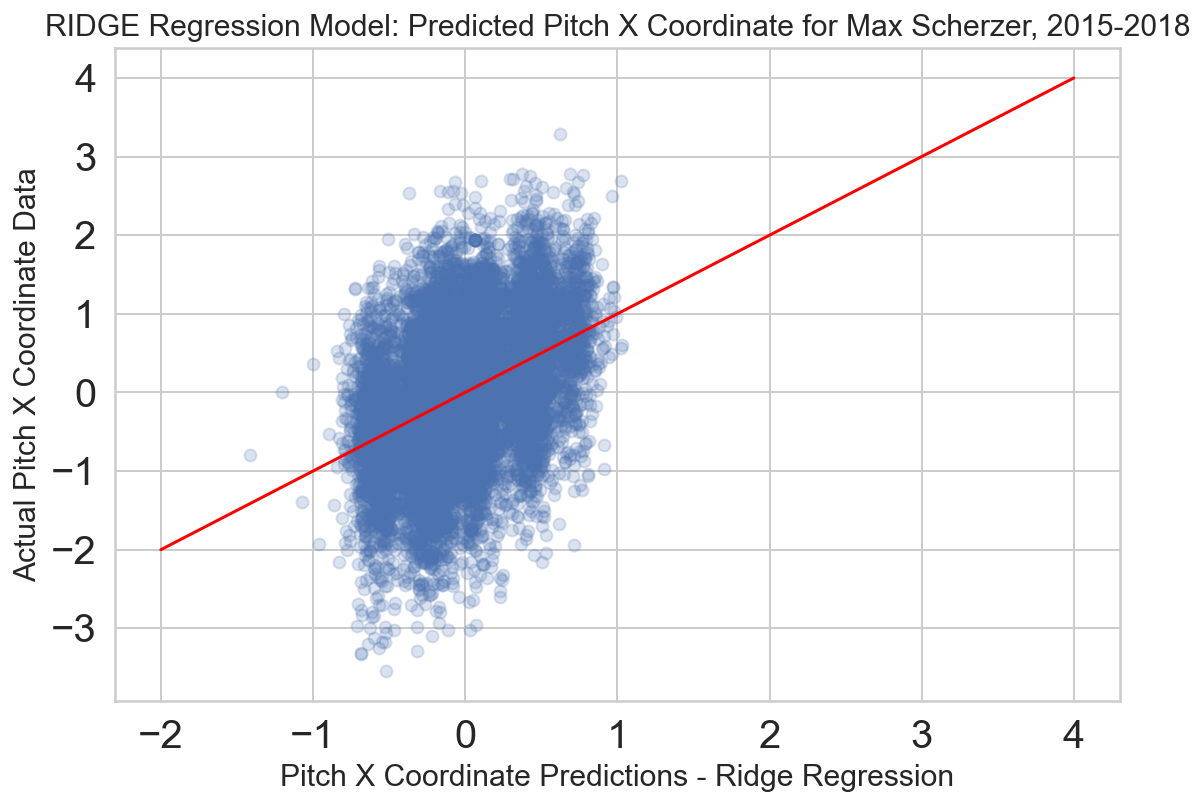

In [58]:
plt.scatter(train_val_pred_px, y, alpha=.2)
plt.plot(np.linspace(-2,4), np.linspace(-2,4), color='red')
plt.xlabel('Pitch X Coordinate Predictions - Ridge Regression', size=15)
plt.ylabel('Actual Pitch X Coordinate Data', size=15)
plt.title('RIDGE Regression Model: Predicted Pitch X Coordinate for Max Scherzer, 2015-2018', size=15)
plt.xticks(size=20)
plt.yticks(size=20);

There is definitely some sort of "blob" effect, where predictions aren't ranging much from -1 past 1: this basically means the model is predicting all the pitches to be over the plate, which tends to make sense.  The actual pitches thrown will tend to always have some sort of outlier, since a pitcher could lose grip, make a wild throw, etc., that an algoritm couldn't necessarily predict.

### Pz:

Now, to check the z (vertical) coordinate.

In [59]:
X = new_df[cols_pz][new_df.last_pitch_px.notnull()]

In [60]:
y = new_df['pz']

In [61]:
std = StandardScaler()
std.fit(X.values)
X_train_val_scaled = std.transform(X.values)

In [62]:
ridge_model = RidgeCV(cv= 5)
ridge_model.fit(X_train_val_scaled, y)
train_val_pred_pz = ridge_model.predict(X_train_val_scaled)

Plotting:

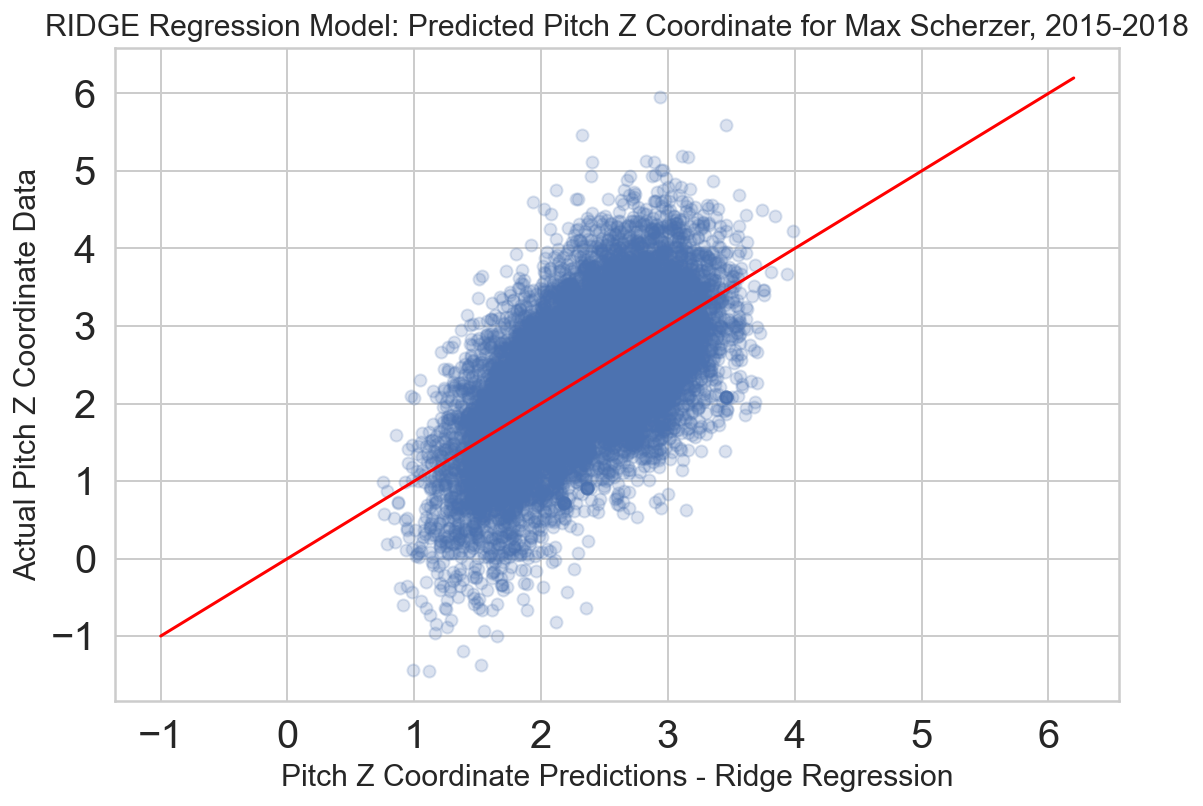

In [63]:
plt.scatter(train_val_pred_pz, y, alpha=.2)
plt.plot(np.linspace(-1,6.2), np.linspace(-1,6.2), color='red')
plt.xlabel('Pitch Z Coordinate Predictions - Ridge Regression', size=15)
plt.ylabel('Actual Pitch Z Coordinate Data', size=15)
plt.title('RIDGE Regression Model: Predicted Pitch Z Coordinate for Max Scherzer, 2015-2018', size=15)
plt.xticks(size=20)
plt.yticks(size=20);

This definitely looks more linear in nature, but there is still a difference between predictions and actual values.  The predictions never predict that a pitch will be "negative", meaning it would bounce in front of the plate.  Same with height, the algorithm doesn't predict a lot of the wild high throws.

### Plotting Both

To get a sense for *where* the algorithm is predicting pitches to go, I am going to plot two plots - one for actual pitch location, the other for predicted.

In [64]:
#Default Strikezone imagine layout - from data_cleaning.ipynb:
def strikezone_layout():
    plt.xlim(-4, 4)
    plt.ylim(0,5)
    plt.hlines(y=1.57, xmin=-0.71, xmax=0.71)
    plt.hlines(y=3.42, xmin=-0.71, xmax=0.71)
    plt.vlines(x=-0.71, ymin=1.57, ymax=3.42)
    plt.vlines(x=0.71, ymin=1.57, ymax=3.42)
    plt.show();

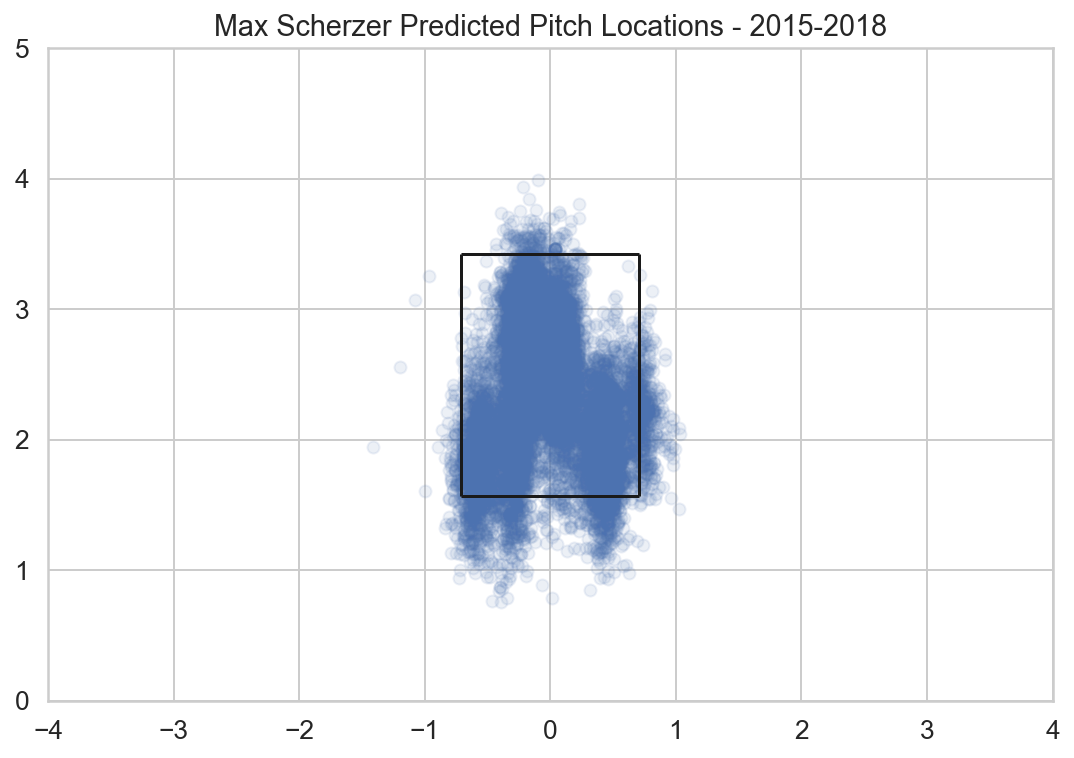

In [65]:
plt.scatter(train_val_pred_px, train_val_pred_pz, alpha = 0.1)
plt.title('Max Scherzer Predicted Pitch Locations - 2015-2018')
strikezone_layout();

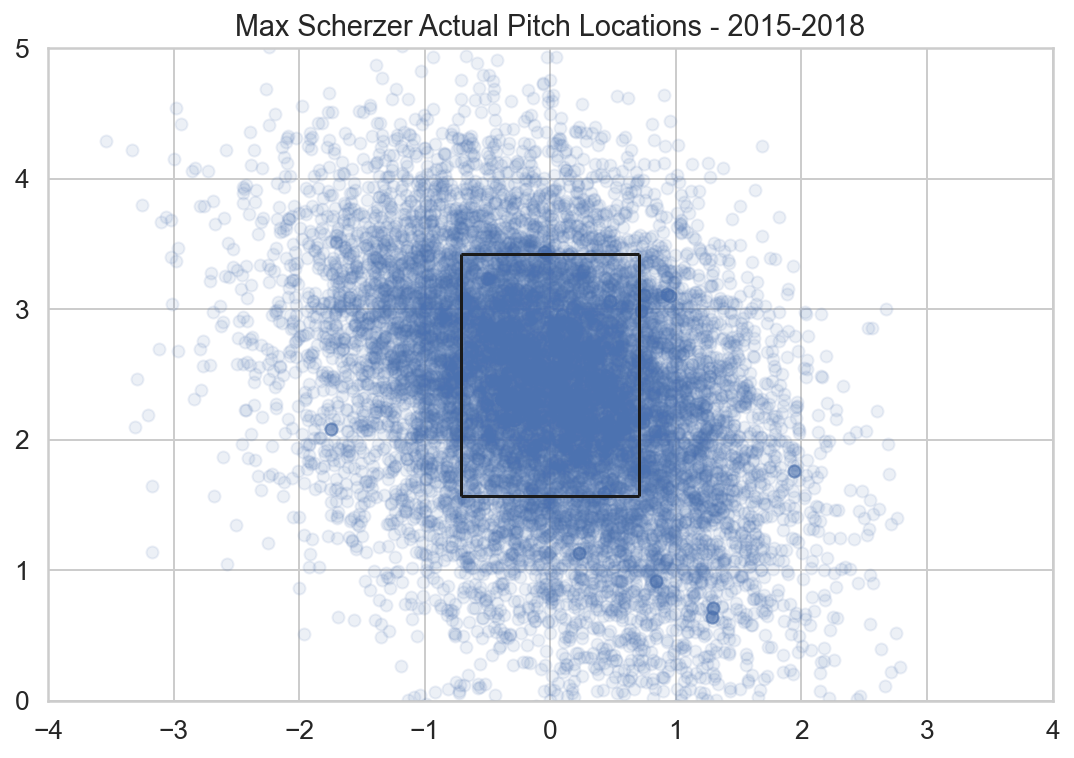

In [66]:
plt.scatter(new_df['px'][new_df.last_pitch_px.notnull()], new_df['pz'][new_df.last_pitch_px.notnull()], alpha = 0.1)
plt.title('Max Scherzer Actual Pitch Locations - 2015-2018')
strikezone_layout();

Clearly, there is a much wider range of pitch locations in real life, as compared to the model.  The model is predicting everything close to the strikezone, perhaps reflecting the "intended" location of the pitch, to an extent.

### Predicted vs. Actual Location - By Pitch Type

Here, I'll see if certain pitches tend to have better predictions than others.

In [67]:
filt_scherzer = scherzer_df[scherzer_df.last_pitch_px.notnull()]

In [68]:
filt_scherzer['Px_Pred'] = train_val_pred_px
filt_scherzer['Pz_Pred'] = train_val_pred_pz

In [69]:
len(filt_scherzer.pitch_type.value_counts().index)

6

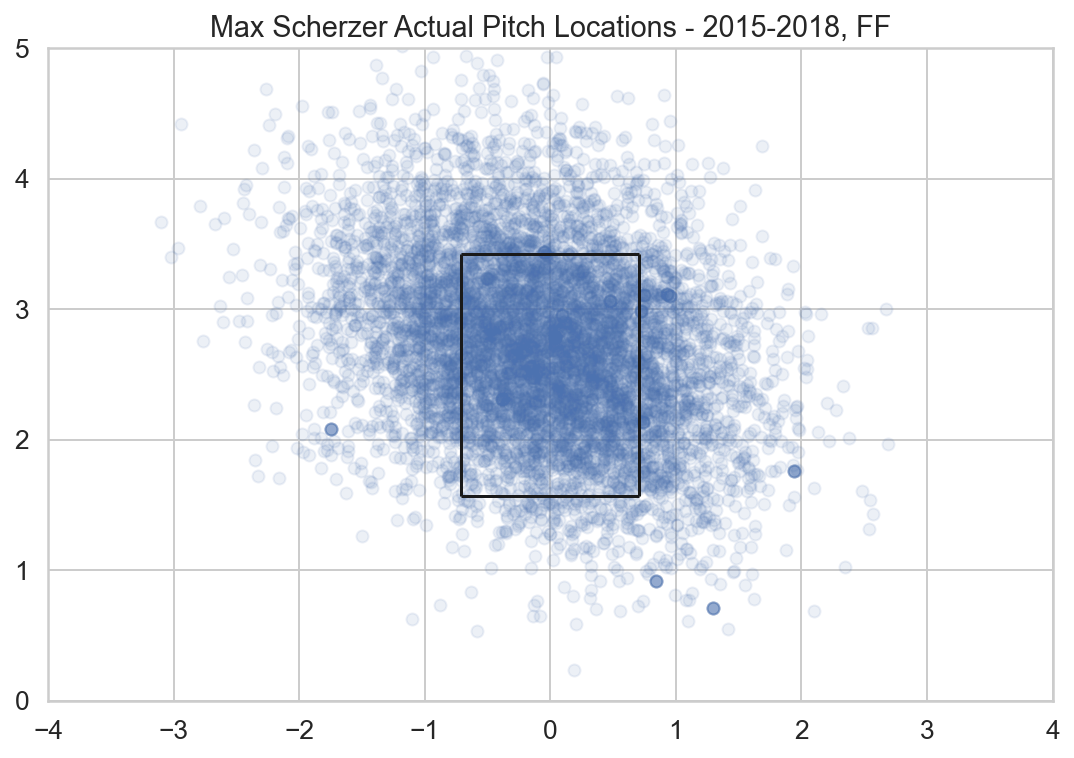

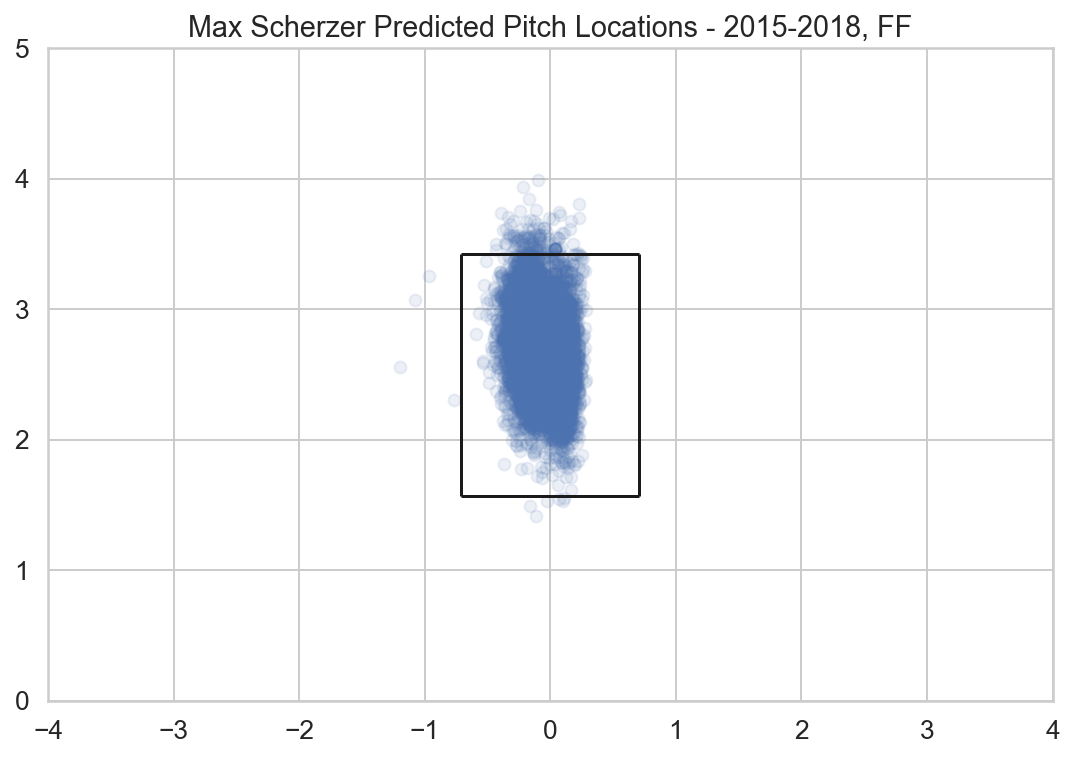

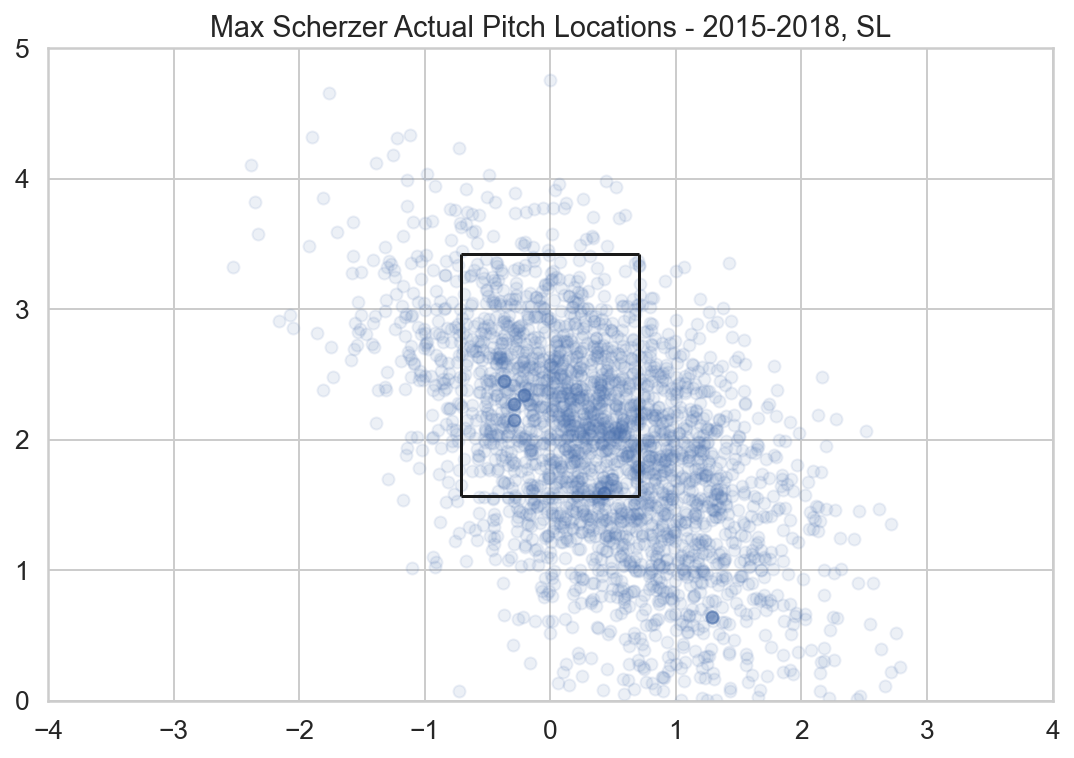

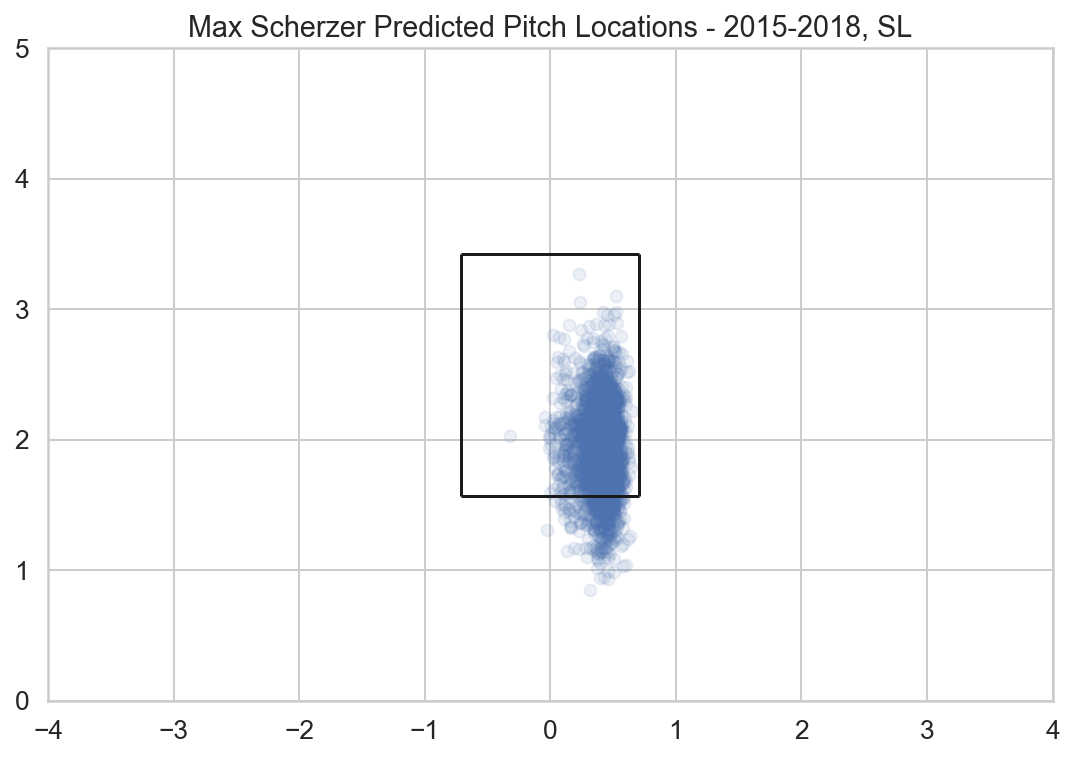

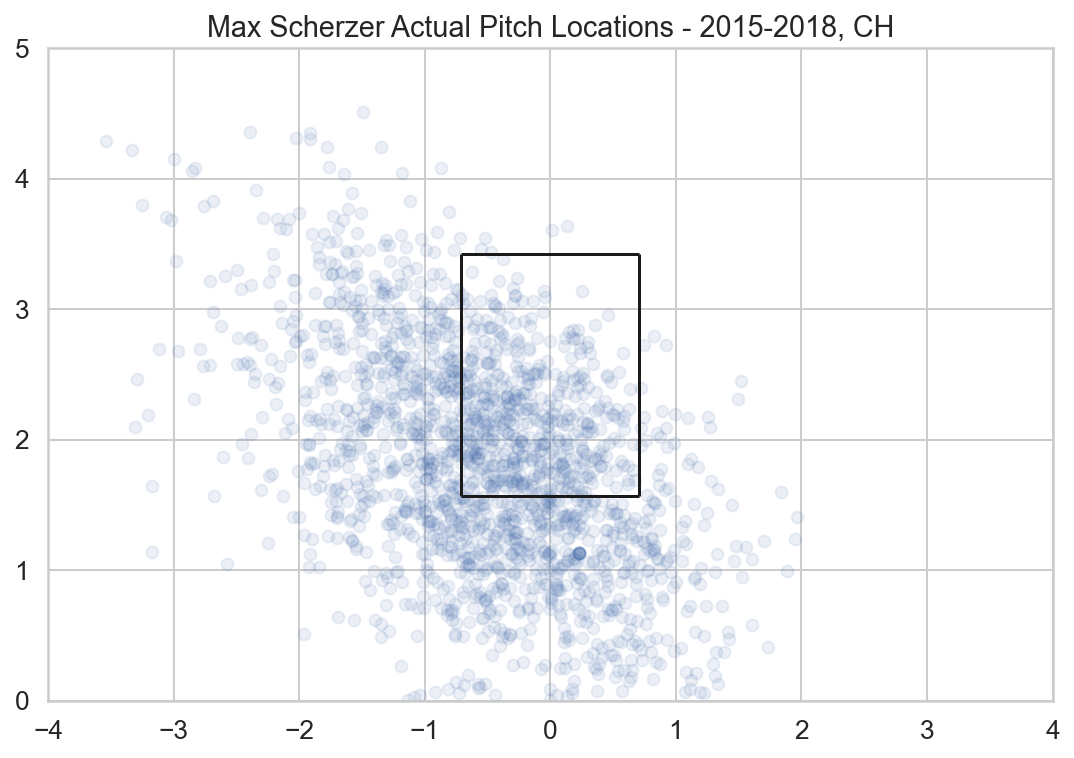

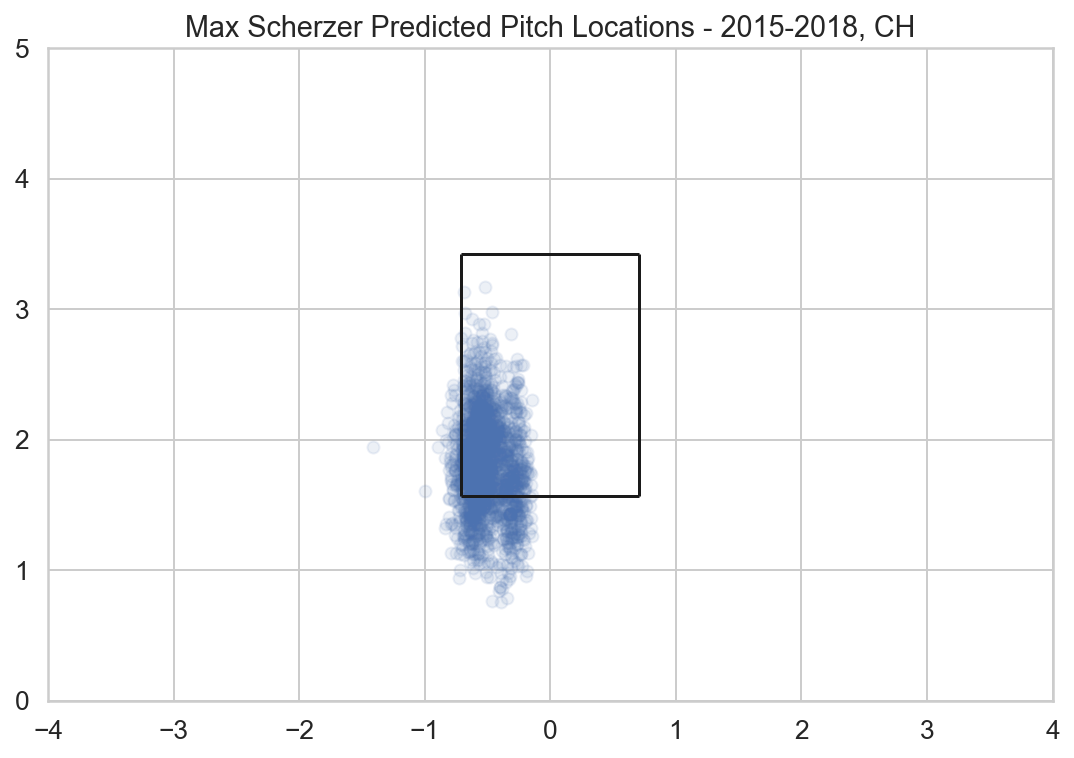

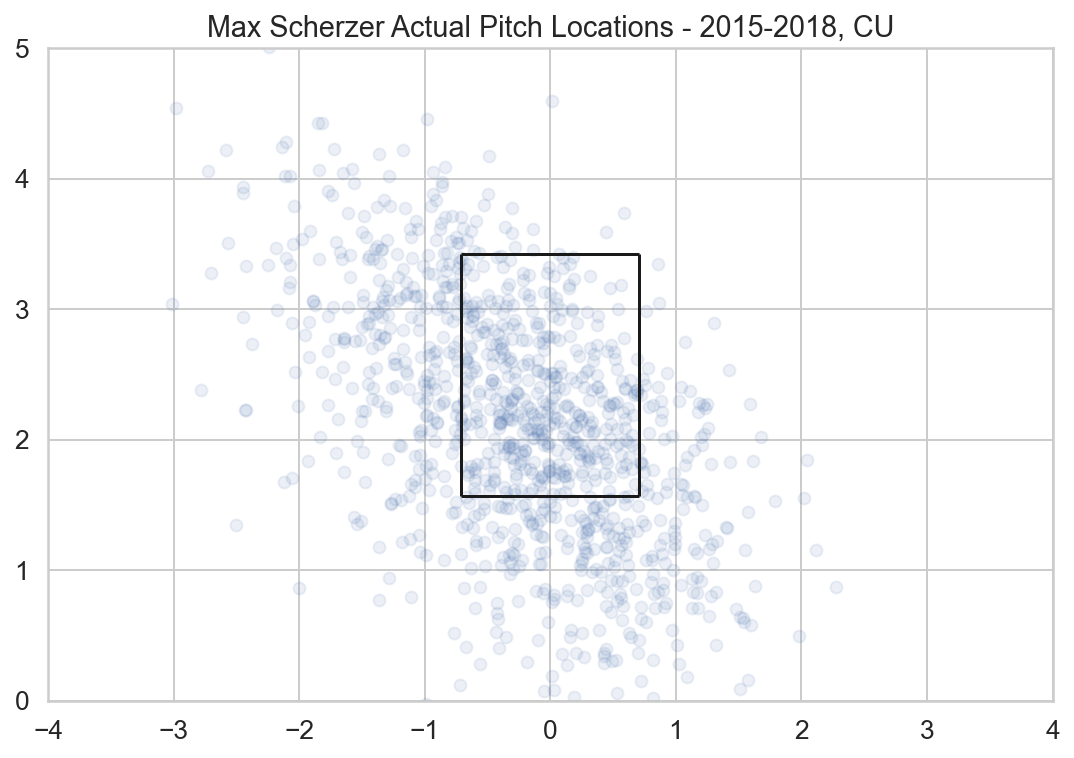

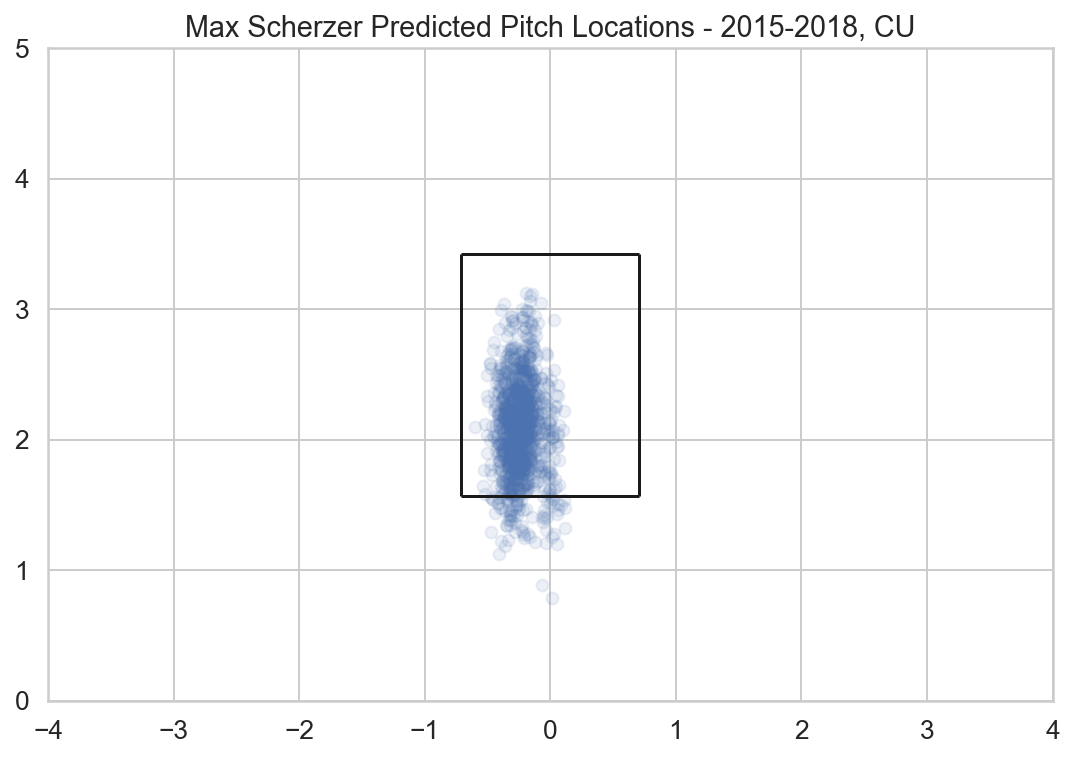

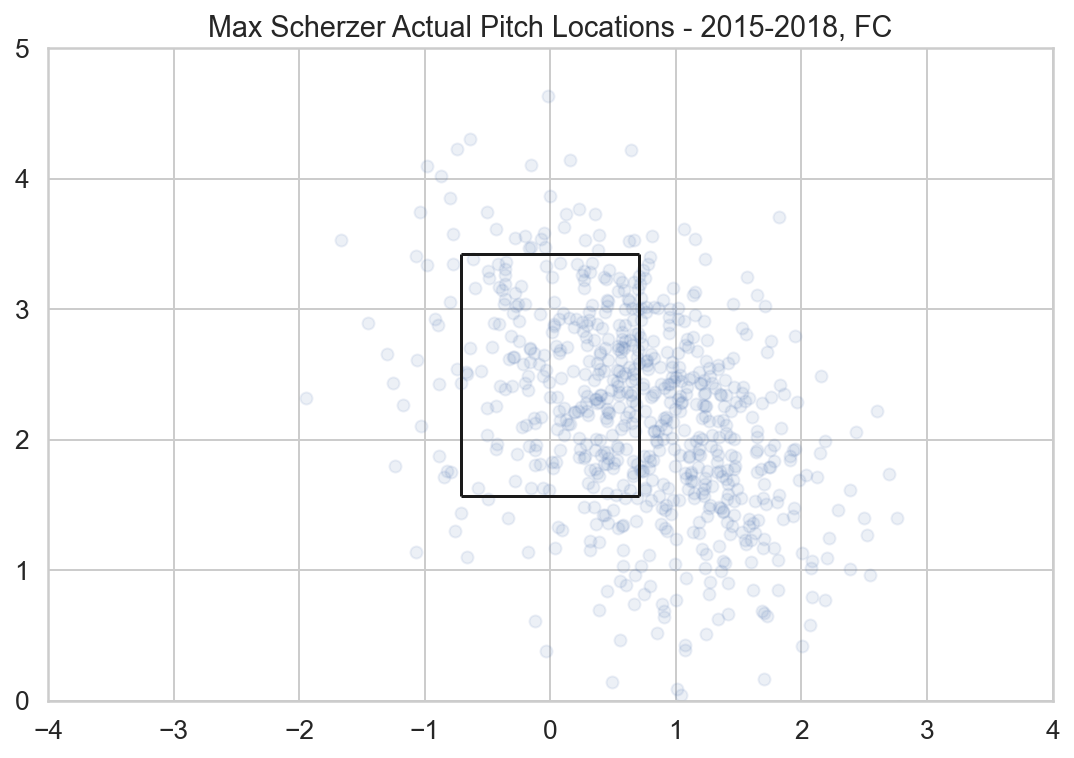

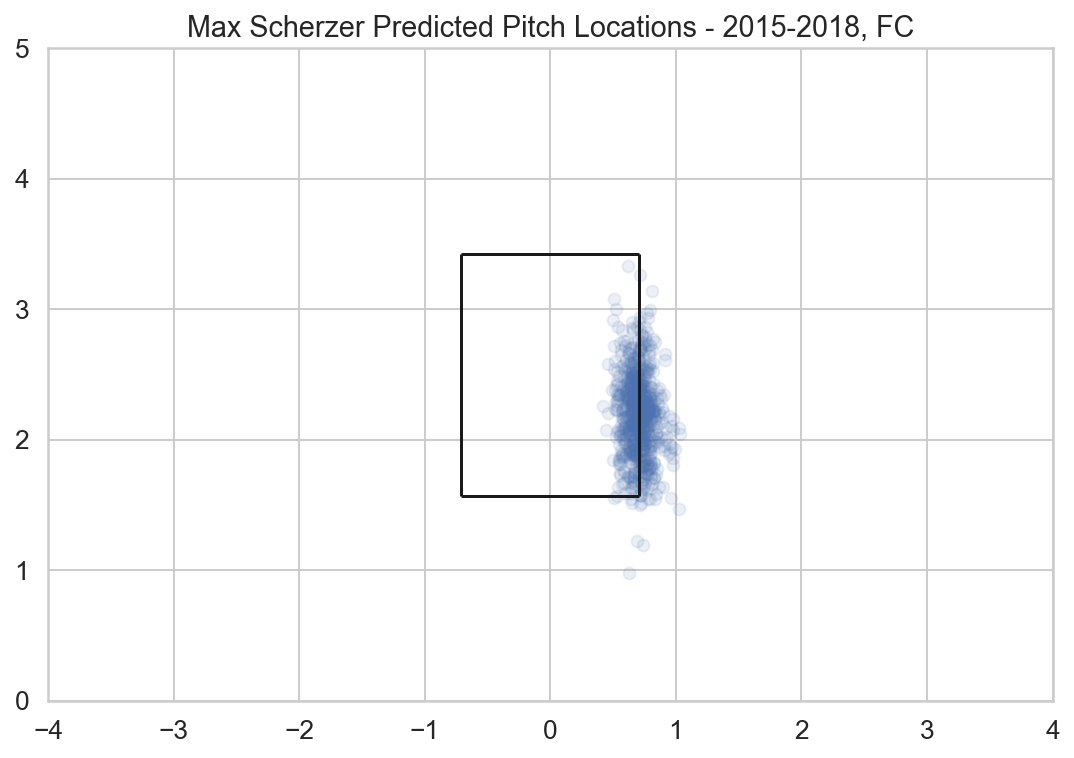

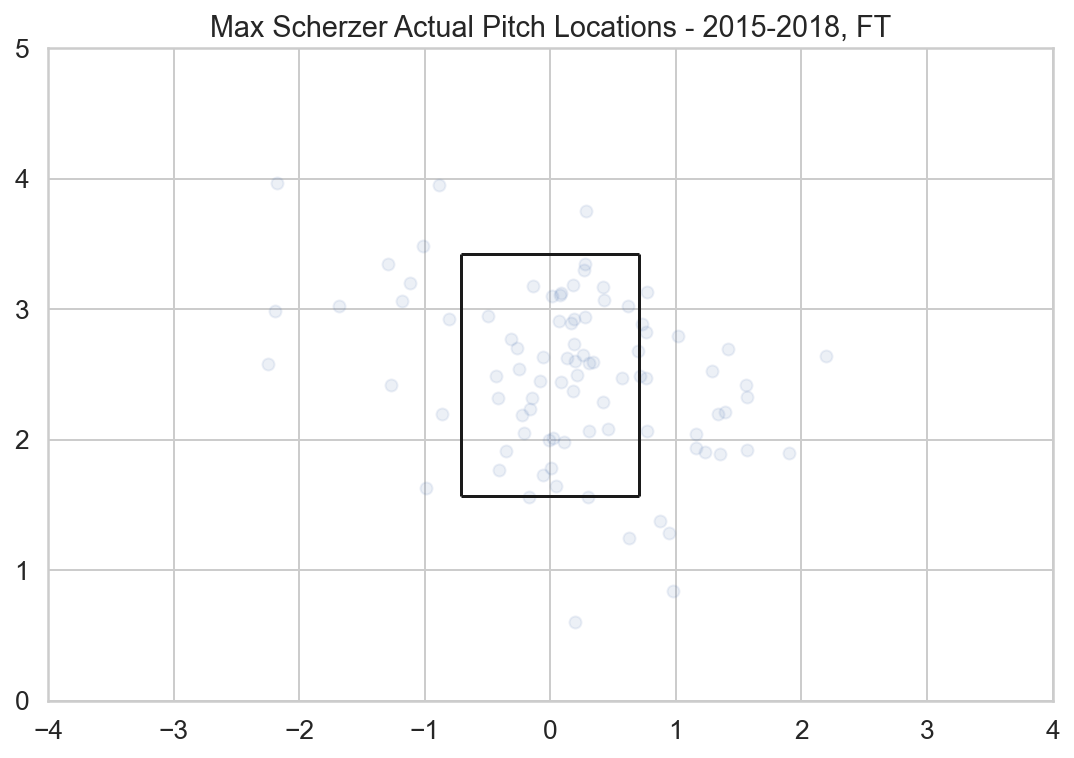

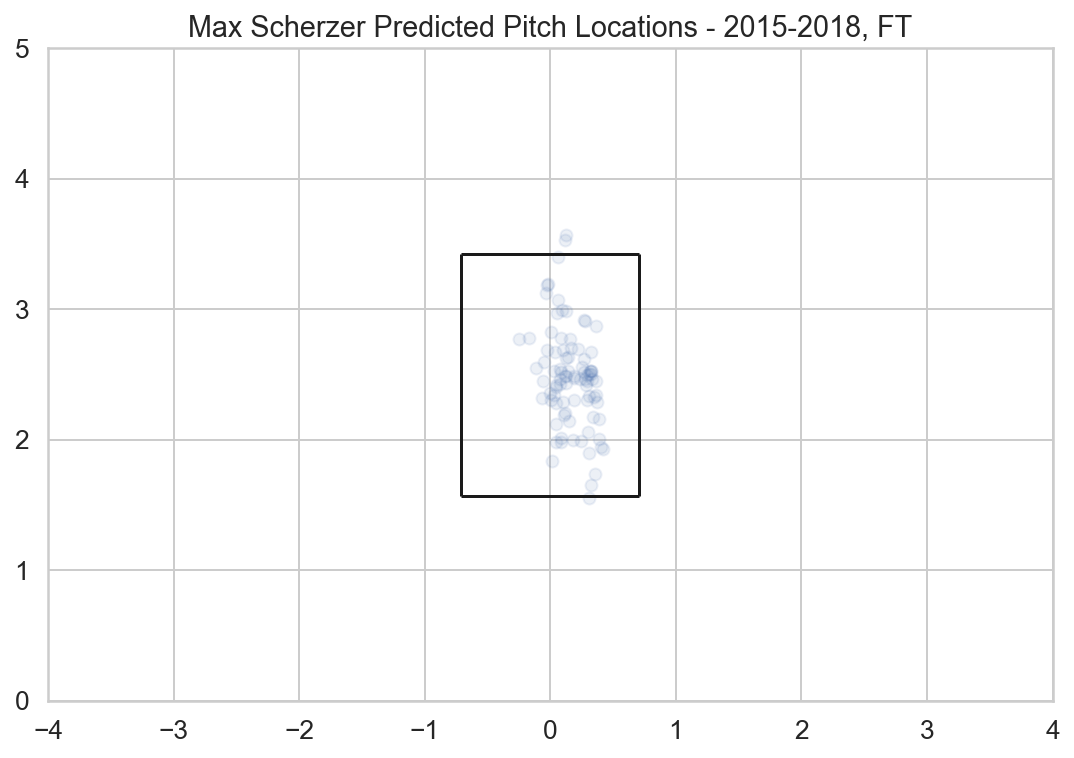

In [70]:
#plt.subplots(6, 2,figsize=(30,30))
for i, pitch_type in enumerate(filt_scherzer.pitch_type.value_counts().index, 1):
    #plt.subplot(6,2,i)
    #Making even numbers actual pitches, odd predicted:
    plt.scatter(filt_scherzer['px'][(filt_scherzer.last_pitch_px.notnull()) & (filt_scherzer.pitch_type == pitch_type)], filt_scherzer['pz'][(filt_scherzer.last_pitch_px.notnull()) & (filt_scherzer.pitch_type == pitch_type)], alpha = 0.1)
    plt.title('Max Scherzer Actual Pitch Locations - 2015-2018, {}'.format(pitch_type))
    strikezone_layout();

    plt.scatter(filt_scherzer['Px_Pred'][(filt_scherzer.last_pitch_px.notnull()) & (filt_scherzer.pitch_type == pitch_type)], filt_scherzer['Pz_Pred'][(filt_scherzer.last_pitch_px.notnull()) & (filt_scherzer.pitch_type == pitch_type)], alpha = 0.1)
    plt.title('Max Scherzer Predicted Pitch Locations - 2015-2018, {}'.format(pitch_type))
    strikezone_layout();
        
    
    
    

It's interesting that it seems to "normalize" where the ball will be thrown in predictions, along a distinct vertical plane for each pitch type.  It does seem like that, while the predictions are off, the algoritm is getting mainly where the pitcher is trying to throw the ball.

For example, for FC (cut fastball), this breaks from left to right.  The algorithm predictions seem to be saying that the ball is going to be breaking away from right handed batters, or in on left handed, on the right edge of the strikezone.  This does make sense logically based on what that pitch is trying to do, with Scherzer being a right handed pitcher (tail away from righties to induce weak contact, or jam lefties and cause a weak grounder).  Slider (SL) behaves in a similar fashion.

### Residual Analysis
Now, I'll take some time to check out where the biggest residuals are.

In [71]:
filt_scherzer['px_res'] = abs(filt_scherzer.px - filt_scherzer.Px_Pred)
filt_scherzer['pz_res'] = abs(filt_scherzer.pz - filt_scherzer.Pz_Pred)

In [72]:
filt_scherzer.groupby('pitch_type').agg({'pitch_num':'count','px_res':'mean', 'pz_res':'mean'})

pitch_num    px_res    pz_res
pitch_type                               
CH               1859  0.686815  0.593387
CU               1089  0.702585  0.651386
FC                688  0.593603  0.538041
FF               7209  0.622648  0.538698
FT                 89  0.631721  0.494053
SL               2679  0.611765  0.537588

Maybe as a game goes on, the pitcher gets more wild (i.e. worse residuals)?

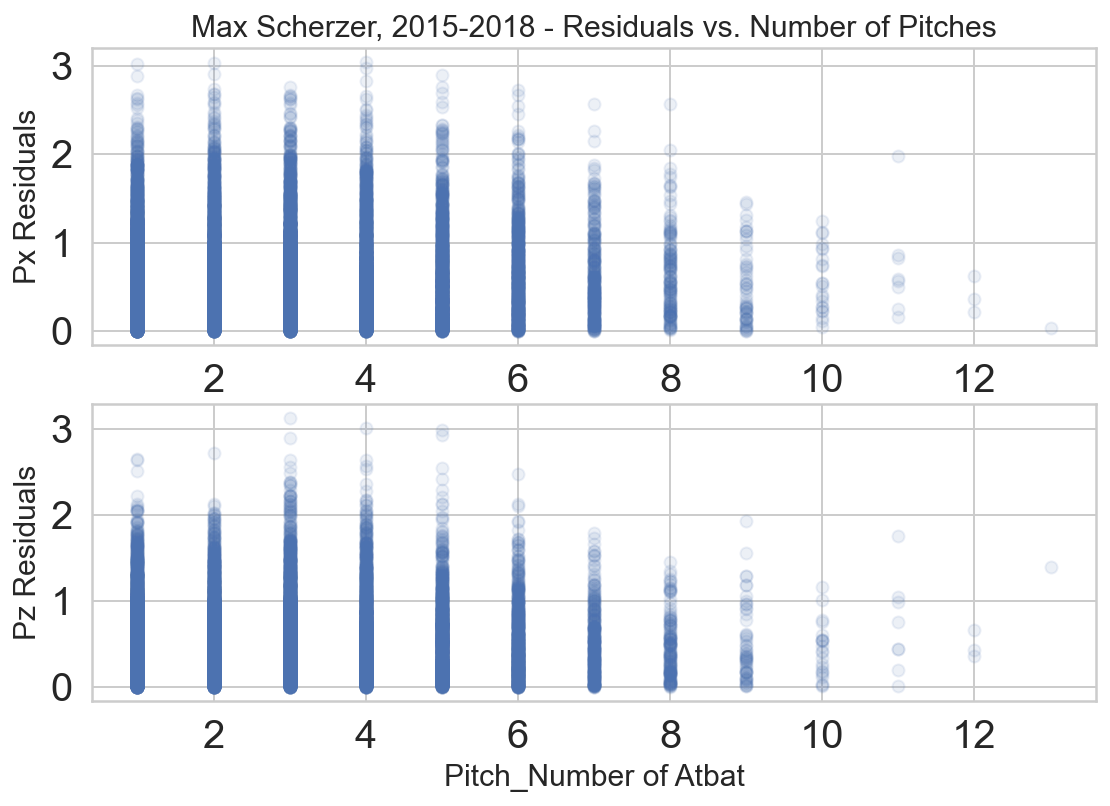

In [73]:
plt.subplot(2,1,1)
plt.scatter(filt_scherzer.pitch_num, filt_scherzer.px_res, alpha=.1)
plt.xlabel('Pitch_Number of Atbat', size=15)
plt.ylabel('Px Residuals', size=15)
plt.title('Max Scherzer, 2015-2018 - Residuals vs. Number of Pitches', size=15)
plt.xticks(size=20)
plt.yticks(size=20);
 
print('\n')
    
plt.subplot(2,1,2)
plt.scatter(filt_scherzer.pitch_num, filt_scherzer.pz_res, alpha=.1)
plt.xlabel('Pitch_Number of Atbat', size=15)
plt.ylabel('Pz Residuals', size=15)
plt.xticks(size=20)
plt.yticks(size=20);

Interestingly enough, it does seem to decrease over the course of an atbat - perhaps, it is better at predicting over at atbat, vs. early on.

### Dallas Keuchel

In [74]:
keuchel_df = clusters_df[(clusters_df.pitcher_full_name == 'Dallas Keuchel') &(clusters_df.last_pitch_px.notnull())]

In [75]:
new_df = column_ohe_maker(keuchel_df, ohe_cols)

In [76]:
new_df.columns

Index(['inning', 'batter_id', 'pitcher_id', 'top', 'ab_id', 'p_score', 'event',
       'home_team', 'away_team', 'b_score', 'on_1b', 'on_2b', 'on_3b', 'px',
       'pz', 'zone', 'start_speed', 'type', 'b_count', 's_count', 'outs',
       'pitch_num', 'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'pitcher_full_name', 'pitcher_run_diff', 'hitter_full_name',
       'Date_Time_Date', 'Season', 'cumulative_pitches', 'cumulative_ff_rate',
       'cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
       'Name', 'Cluster', 'stand_R', 'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FT', 'last_pitch_type_SL',
       'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT', 'pitch_type_SL'],
      dtype='object')

### Linear Regression Test:

In [77]:
columns = ['inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'Cluster','cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
           'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FT', 'last_pitch_type_SL',
       'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT', 'pitch_type_SL']

In [78]:
X = new_df[columns][new_df.last_pitch_px.notnull()]

In [79]:
y = new_df['px']

In [80]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.32494268374506097, 0.3378257863022518, 0.3541617970645963, 0.3661774149270106, 0.34215641920266093] 

Simple mean cv r^2: 0.345 +- 0.014
MAE Scores: [0.5695650787767146, 0.5745936120351943, 0.5623675761723176, 0.5589174043896208, 0.5530438384459656]
Avg. CV MAE: 0.5636975019639626


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.34377489015600504
Lasso mae: 0.5648790967924138
Lasso Coefficients: [('inning', 0.0), ('b_count', -0.018390942839875888), ('s_count', -0.08037889915984939), ('outs', 0.0030237119910512507), ('pitcher_run_diff', 0.009935802711311269), ('stand_R', 0.1494844628097351), ('Cluster', -0.0), ('cumulative_sl_rate', -0.0), ('cumulative_ft_rate', 0.010551159958432513), ('cumulative_ch_rate', -0.0), ('cumulative_cu_rate', 0.0), ('cumulative_si_rate', 0.0), ('cumulative_fc_rate', 0.024102644100081606), ('cumulative_kc_rate', 0.0), ('cumulative_fs_rate', 0.0), ('cumulative_kn_rate', 0.0), ('cum

Checking on pz, using px as a feature:

In [81]:
cols_pz = ['px','inning', 'b_count', 's_count', 'outs', 'pitcher_run_diff', 'stand_R',
          'Cluster','cumulative_sl_rate', 'cumulative_ft_rate', 'cumulative_ch_rate',
       'cumulative_cu_rate', 'cumulative_si_rate', 'cumulative_fc_rate',
       'cumulative_kc_rate', 'cumulative_fs_rate', 'cumulative_kn_rate',
       'cumulative_ep_rate', 'cumulative_fo_rate', 'cumulative_sc_rate',
           'last_pitch_px', 'last_pitch_pz', 'last_pitch_speed',
       'last_pitch_type_FC',
       'last_pitch_type_FF', 'last_pitch_type_FT', 'last_pitch_type_SL',
       'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FT', 'pitch_type_SL']

In [82]:
X = new_df[cols_pz]

In [83]:
y = new_df['pz']

In [84]:
validation_comparer(X,y)

Simple Linear Regression w/ KFOLD CV Results:
Simple regression scores:  [0.18711058379486478, 0.1686378133495371, 0.1493522105458116, 0.19495271657781132, 0.16269066983039893] 

Simple mean cv r^2: 0.173 +- 0.017
MAE Scores: [0.6531448928942633, 0.6377920373798913, 0.6425853708289725, 0.6475385023893804, 0.6431873571898615]
Avg. CV MAE: 0.6448496321364737


Lasso Linear Regression w/ CV Results:
Lasso R^2: 0.17347899006030731
Lasso mae: 0.6450908866389272
Lasso Coefficients: [('px', 0.1438333193214291), ('inning', 0.0030375388911824813), ('b_count', 0.044550174041468424), ('s_count', -0.08131030721560704), ('outs', -0.013024082668472738), ('pitcher_run_diff', 0.003856368955947685), ('stand_R', -0.025322485476959887), ('Cluster', -0.009034760748004812), ('cumulative_sl_rate', -0.0), ('cumulative_ft_rate', 0.0), ('cumulative_ch_rate', 0.007241794680796135), ('cumulative_cu_rate', 0.0), ('cumulative_si_rate', 0.0), ('cumulative_fc_rate', -0.008569282449898817), ('cumulative_kc_rate', 0.0

This is slightly better, but only in the thousandths place.  The MAE does not seem to significantly change.

### Px:

In [85]:
X = new_df[columns][new_df.last_pitch_px.notnull()]

In [86]:
y = new_df['px']

In [87]:
std = StandardScaler()
std.fit(X.values)
X_train_val_scaled = std.transform(X.values)

In [88]:
ridge_model = RidgeCV(cv= 5)
ridge_model.fit(X_train_val_scaled, y)
train_val_pred_px = ridge_model.predict(X_train_val_scaled)

Plotting:

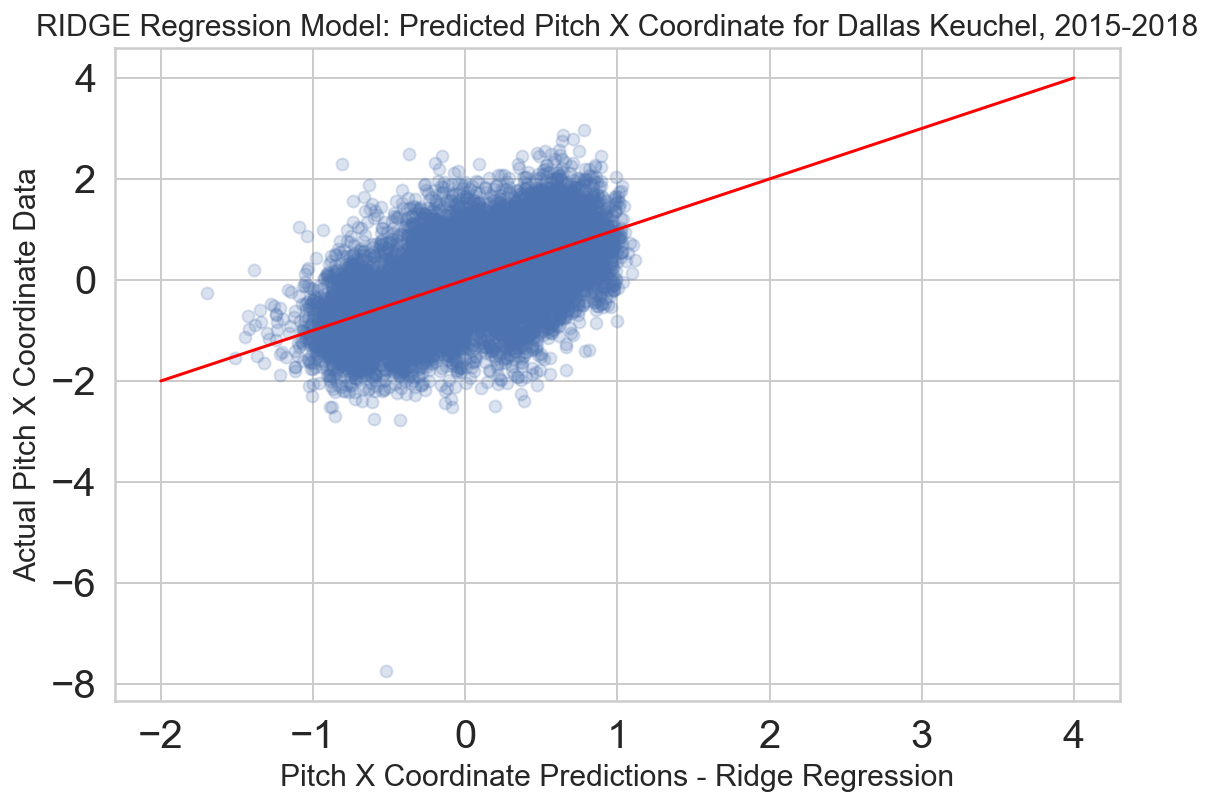

In [89]:
plt.scatter(train_val_pred_px, y, alpha=.2)
plt.plot(np.linspace(-2,4), np.linspace(-2,4), color='red')
plt.xlabel('Pitch X Coordinate Predictions - Ridge Regression', size=15)
plt.ylabel('Actual Pitch X Coordinate Data', size=15)
plt.title('RIDGE Regression Model: Predicted Pitch X Coordinate for Dallas Keuchel, 2015-2018', size=15)
plt.xticks(size=20)
plt.yticks(size=20);

There is definitely some sort of "blob" effect, where predictions aren't ranging much from -1 past 1: this basically means the model is predicting all the pitches to be over the plate, which tends to make sense.  The actual pitches thrown will tend to always have some sort of outlier, since a pitcher could lose grip, make a wild throw, etc., that an algoritm couldn't necessarily predict.

### Pz:

Now, to check the z (vertical) coordinate.

In [90]:
X = new_df[cols_pz][new_df.last_pitch_px.notnull()]

In [91]:
y = new_df['pz']

In [92]:
std = StandardScaler()
std.fit(X.values)
X_train_val_scaled = std.transform(X.values)

In [93]:
ridge_model = RidgeCV(cv= 5)
ridge_model.fit(X_train_val_scaled, y)
train_val_pred_pz = ridge_model.predict(X_train_val_scaled)

Plotting:

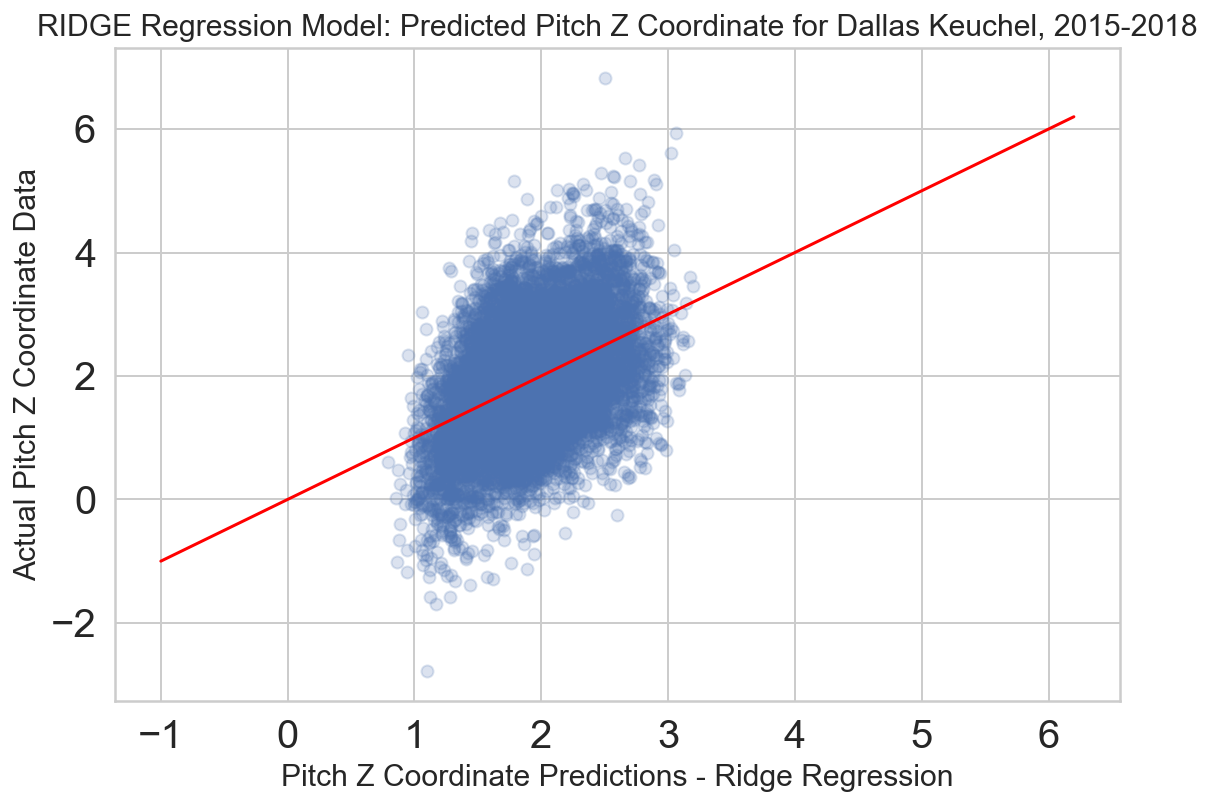

In [94]:
plt.scatter(train_val_pred_pz, y, alpha=.2)
plt.plot(np.linspace(-1,6.2), np.linspace(-1,6.2), color='red')
plt.xlabel('Pitch Z Coordinate Predictions - Ridge Regression', size=15)
plt.ylabel('Actual Pitch Z Coordinate Data', size=15)
plt.title('RIDGE Regression Model: Predicted Pitch Z Coordinate for Dallas Keuchel, 2015-2018', size=15)
plt.xticks(size=20)
plt.yticks(size=20);

This definitely looks more linear in nature, but there is still a difference between predictions and actual values.  The predictions never predict that a pitch will be "negative", meaning it would bounce in front of the plate.  Same with height, the algorithm doesn't predict a lot of the wild high throws.

### Plotting Both

To get a sense for *where* the algorithm is predicting pitches to go, I am going to plot two plots - one for actual pitch location, the other for predicted.

In [95]:
#Default Strikezone imagine layout - from data_cleaning.ipynb:
def strikezone_layout():
    plt.xlim(-4, 4)
    plt.ylim(0,5)
    plt.hlines(y=1.57, xmin=-0.71, xmax=0.71)
    plt.hlines(y=3.42, xmin=-0.71, xmax=0.71)
    plt.vlines(x=-0.71, ymin=1.57, ymax=3.42)
    plt.vlines(x=0.71, ymin=1.57, ymax=3.42)
    plt.show();

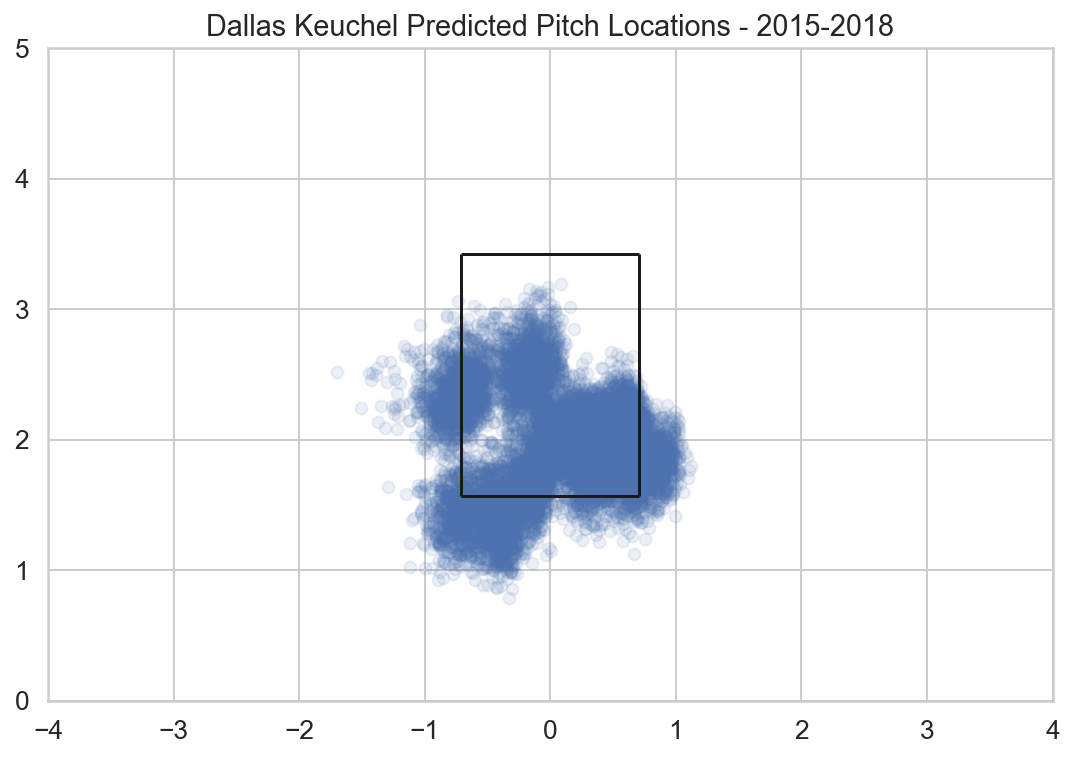

In [96]:
plt.scatter(train_val_pred_px, train_val_pred_pz, alpha = 0.1)
plt.title('Dallas Keuchel Predicted Pitch Locations - 2015-2018')
strikezone_layout();

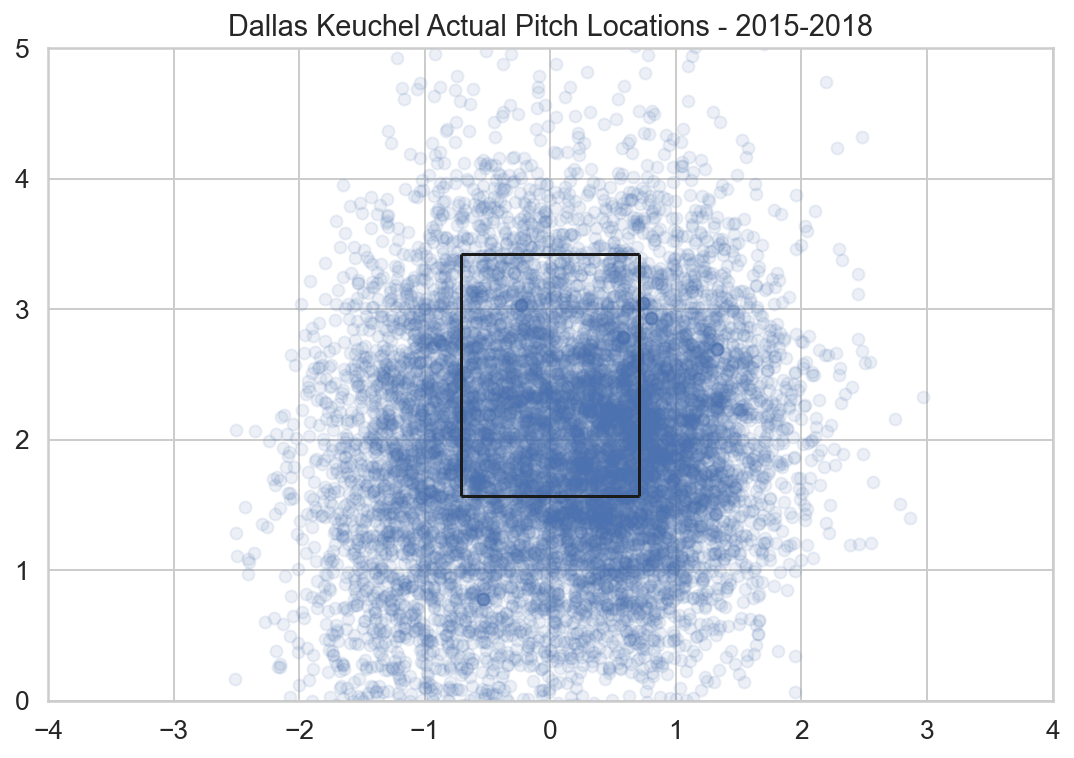

In [97]:
plt.scatter(new_df['px'][new_df.last_pitch_px.notnull()], new_df['pz'][new_df.last_pitch_px.notnull()], alpha = 0.1)
plt.title('Dallas Keuchel Actual Pitch Locations - 2015-2018')
strikezone_layout();

Clearly, there is a much wider range of pitch locations in real life, as compared to the model.  The model is predicting everything close to the strikezone.

### Predicted vs. Actual Location - By Pitch Type

Here, I'll see if certain pitches tend to have better predictions than others.

In [98]:
filt_keuchel = keuchel_df[keuchel_df.last_pitch_px.notnull()]

In [99]:
filt_keuchel['Px_Pred'] = train_val_pred_px
filt_keuchel['Pz_Pred'] = train_val_pred_pz

In [100]:
len(filt_keuchel.pitch_type.value_counts().index)

5

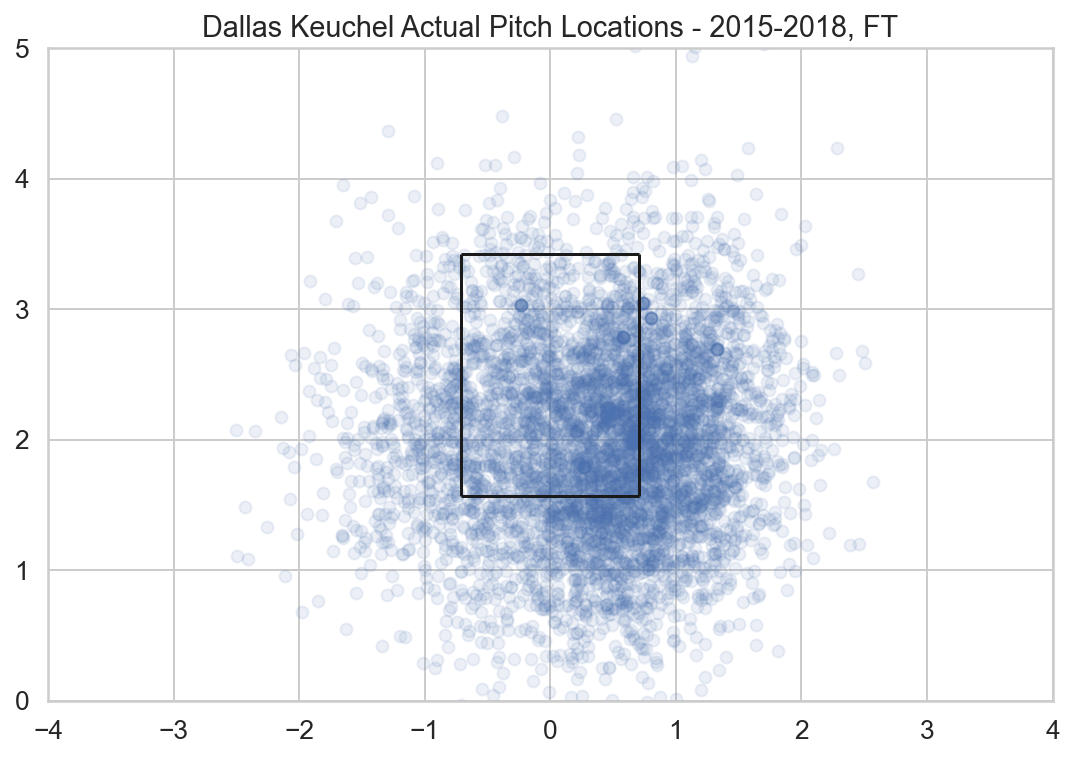

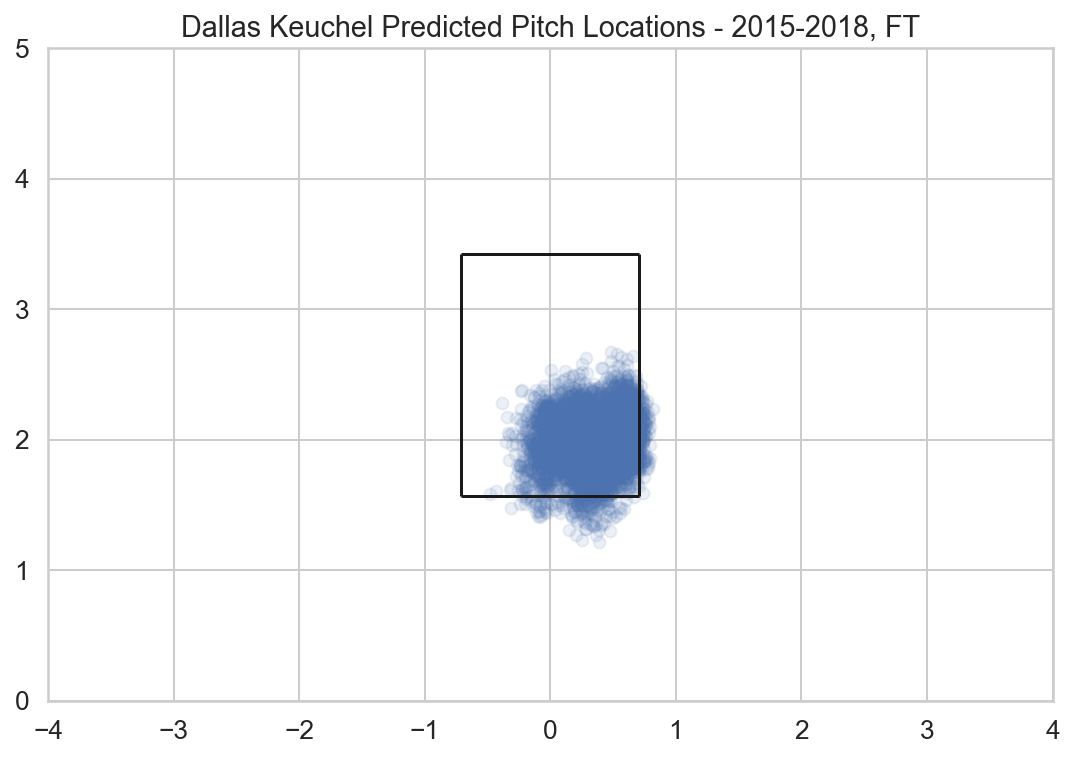

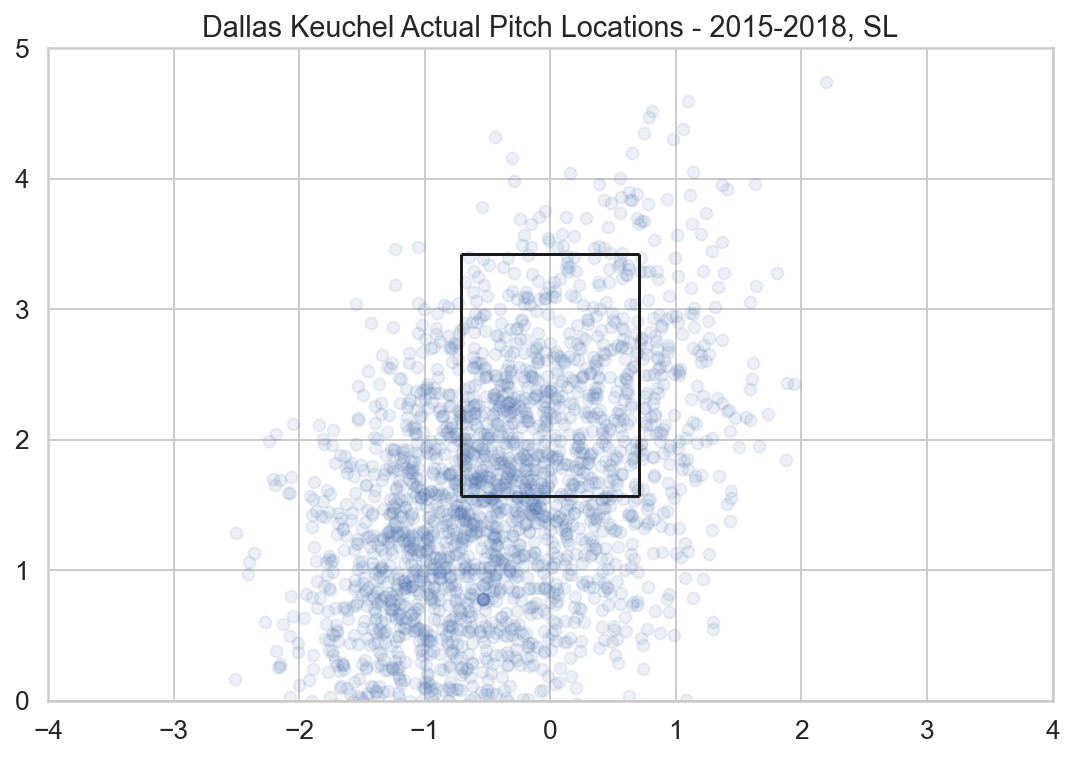

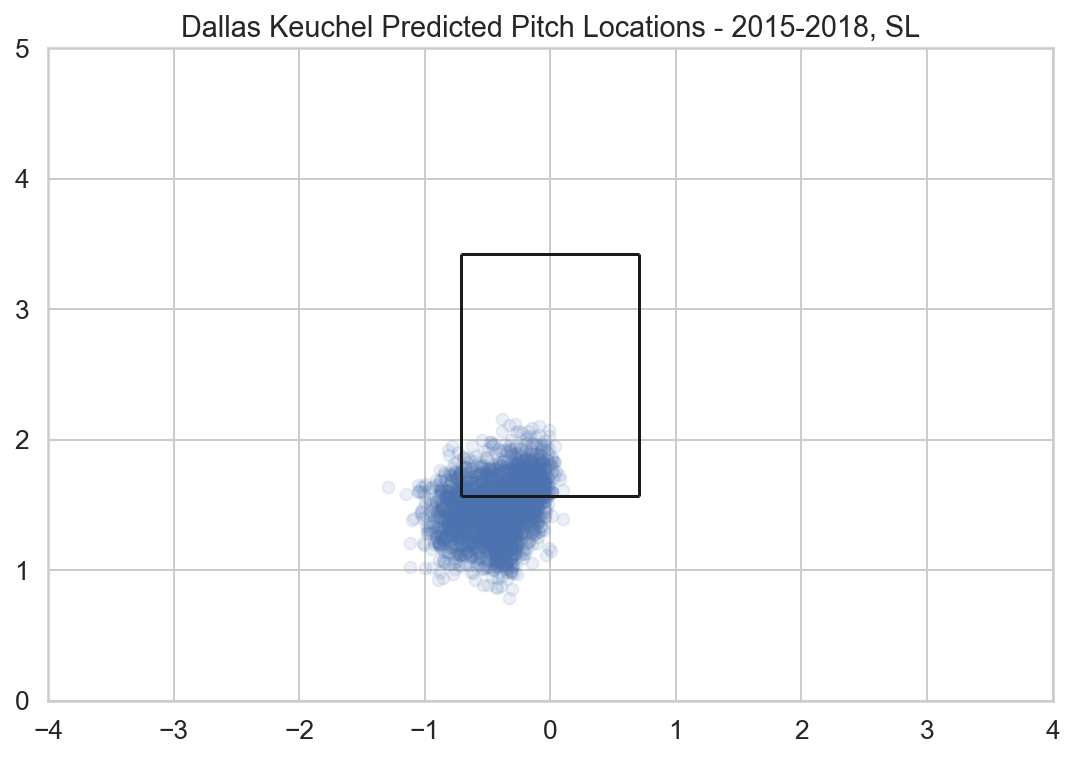

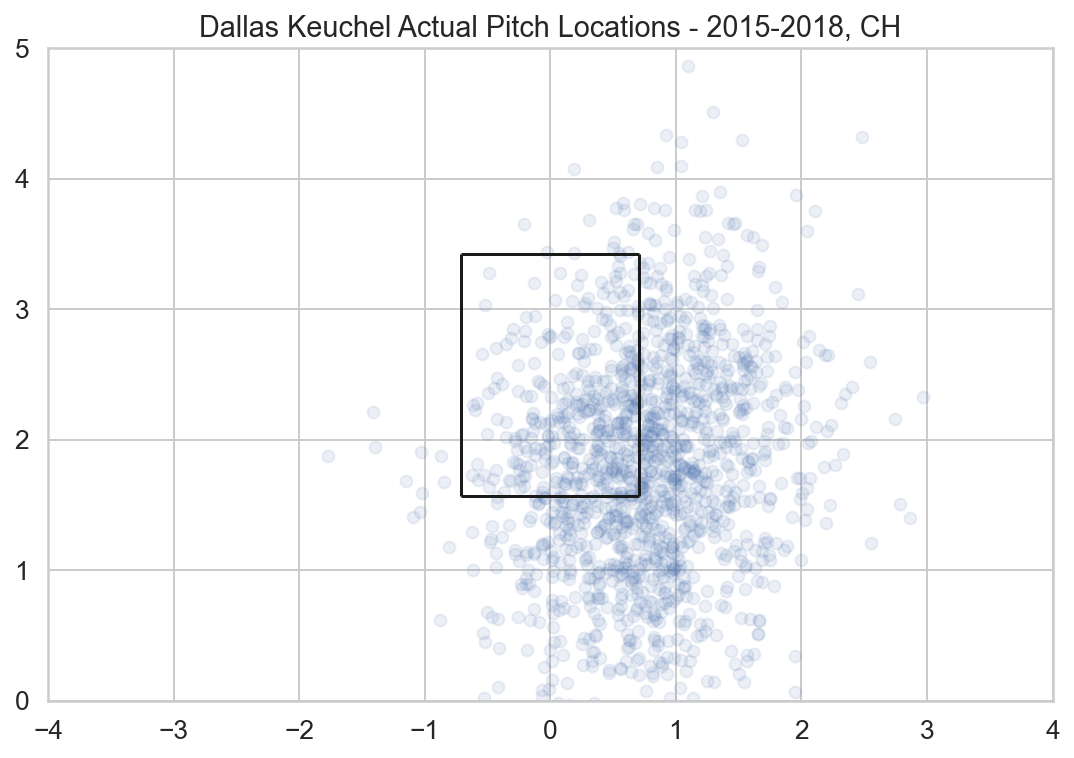

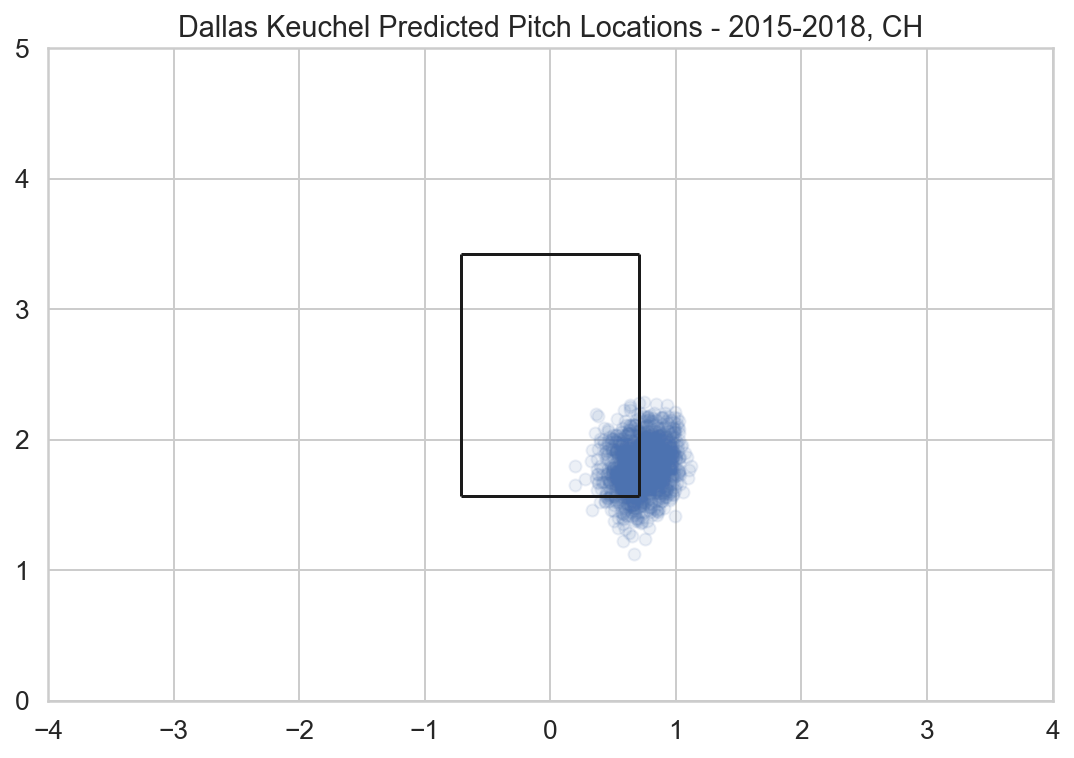

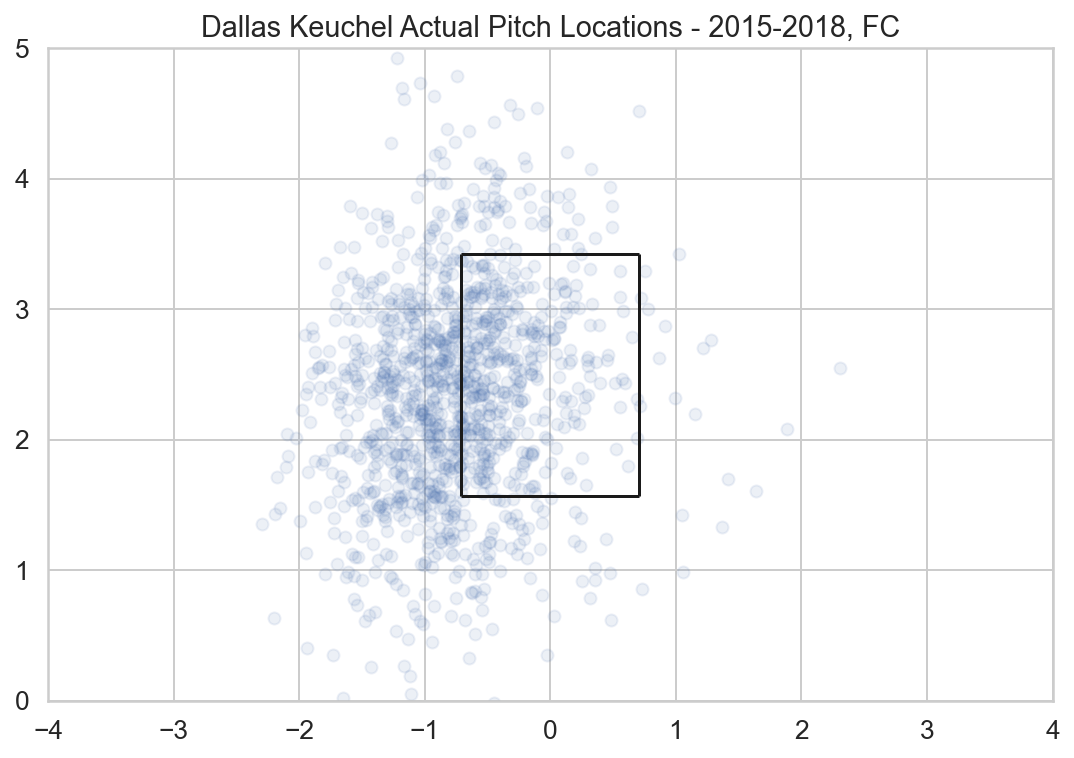

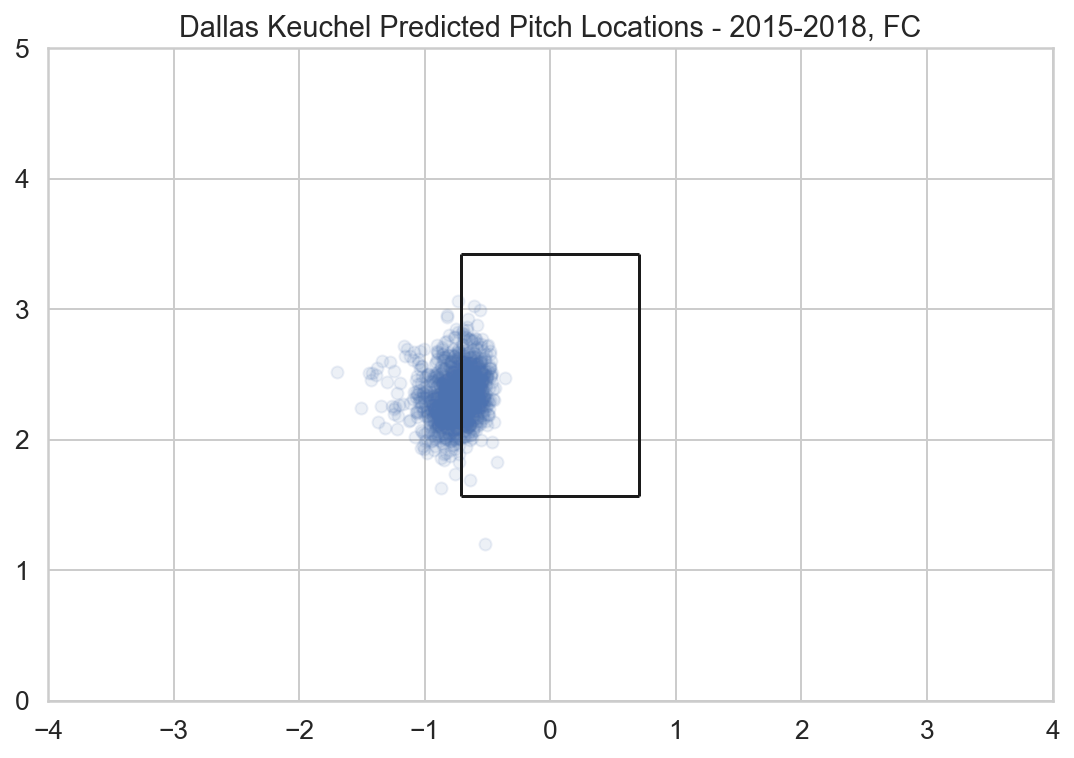

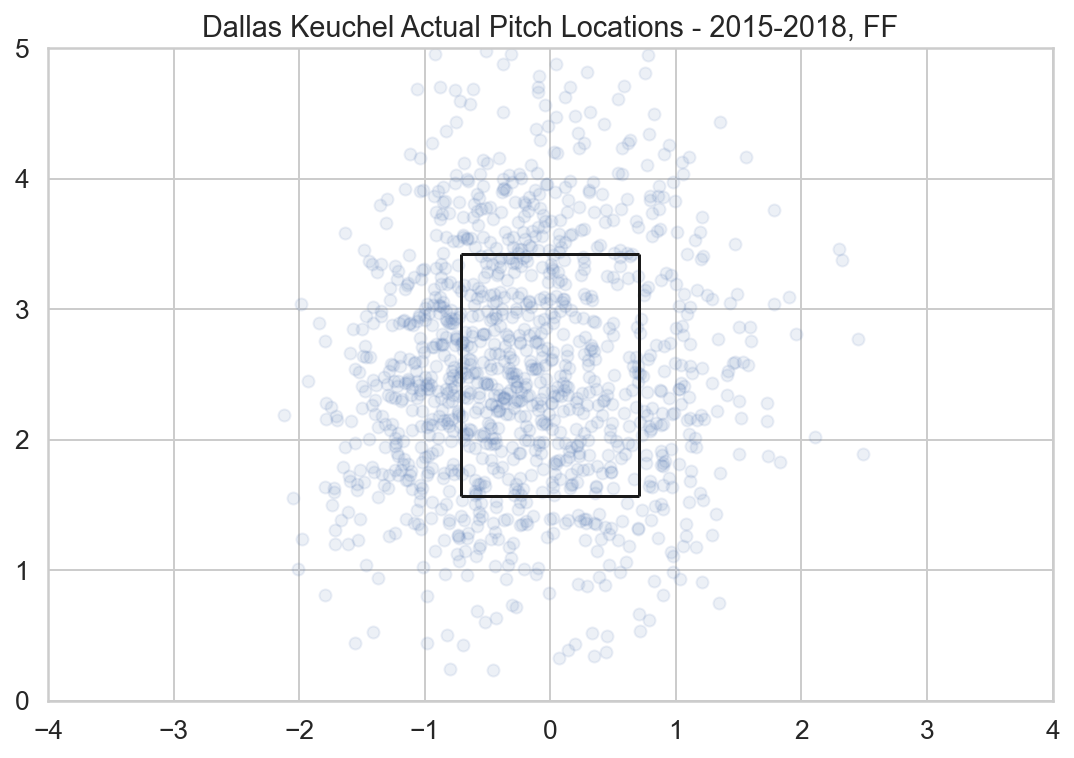

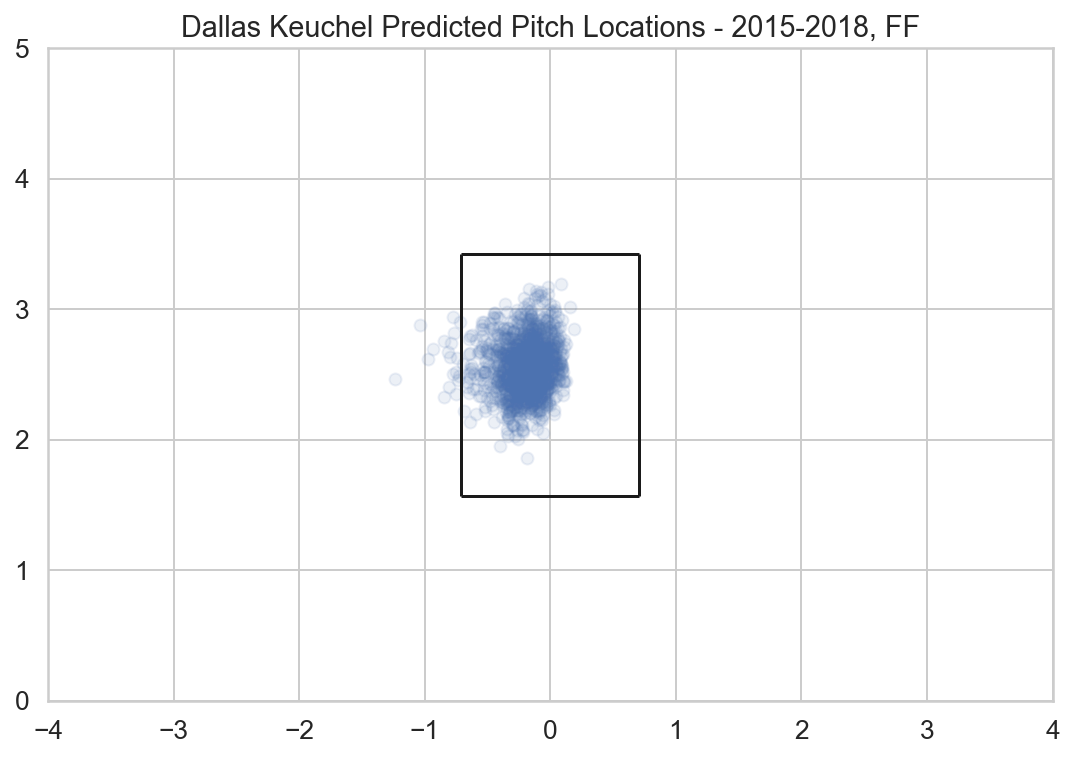

In [101]:
#plt.subplots(6, 2,figsize=(30,30))
for i, pitch_type in enumerate(filt_keuchel.pitch_type.value_counts().index, 1):
    #plt.subplot(6,2,i)
    #Making even numbers actual pitches, odd predicted:
    plt.scatter(filt_keuchel['px'][(filt_keuchel.last_pitch_px.notnull()) & (filt_keuchel.pitch_type == pitch_type)], filt_keuchel['pz'][(filt_keuchel.last_pitch_px.notnull()) & (filt_keuchel.pitch_type == pitch_type)], alpha = 0.1)
    plt.title('Dallas Keuchel Actual Pitch Locations - 2015-2018, {}'.format(pitch_type))
    strikezone_layout();

    plt.scatter(filt_keuchel['Px_Pred'][(filt_keuchel.last_pitch_px.notnull()) & (filt_keuchel.pitch_type == pitch_type)], filt_keuchel['Pz_Pred'][(filt_keuchel.last_pitch_px.notnull()) & (filt_keuchel.pitch_type == pitch_type)], alpha = 0.1)
    plt.title('Dallas Keuchel Predicted Pitch Locations - 2015-2018, {}'.format(pitch_type))
    strikezone_layout();
        
    
    
    

These tend to make sense, with the pitch type predicted locations tending to be where the pitcher would want the ball.

# NEXT: pipeline_architecture.ipynb
In that notebook, I'll begin work on chaining together the classification algorithm and regression algorithms for the x and y coordinates (px and pz).